<a href="https://colab.research.google.com/github/rpedram/data-science/blob/main/Cab_Rides_class_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cab Ride
Simply learn python class work: Instr- Sujata Date 30 Mar
**Objectives**

1.   Data Wrangling
2.   Feature Engg


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
# Pt to note delare only libraries called for in main current notebook. Libraries required by functions in modules are declared only in module.

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# For importing lib in colab change sys path to where i upload my .py files
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

# Made a library of my EDA function and plotting comparision for reuse in projects
# This has to be .py file
import my_library_functions as rak

# In my main code. Test import of module. Print a line confirming import
print(rak.test_function())

# Load sample data
data = rak.load_data("Cab_Rides.csv")
data.info()
type(data)

# EDA

import re
# Rem all spl characters in colns and convert to lower case
# You can add re statement to rem spaces in field name and convert to snake case
#Knock off all spl char from your field names. easy coding

def rename_col(df):

    def to_snake_case(name):
        name = re.sub(r'[^a-zA-Z0-9_]', '', name)  # Remove special characters (except alphanumeric and underscore)

        return name.lower()  # Convert to lowercase

    df.rename(columns=to_snake_case, inplace=True)
    return df
# Call rename column function
df=rename_col(data.copy())


## Convert to date time field
This is typical work flow for mixed date time data you find in simply learn db. Its mix of EU and US formats. single shot conversion is not feasible
I find excel power query best for doing this. Double check so that you dont loose data. few fields left after these transformation- drop the rows

* Re-run  line 13,14 every time you load even the cleaned csv as fields auto gets reset to obj on imporing from csv and code wont run

In [ ]:
def convert_to_datetime(date_str, format_str):
    try:
        return pd.to_datetime(date_str, format=format_str)
    except ValueError:
        print(f"Error converting '{date_str}'. Check the format.")
        return date_str # Change this to from date_str to None in second run
# First apply eu format %d-%m-%Y then apply american format
# Typical simply learn db datafield mix of eu and american date format can also use excel power query for transform
df['start_date'] = df['start_date'].apply(convert_to_datetime, format_str="%d-%m-%Y %H:%M")
df['end_date'] = df['end_date'].apply(convert_to_datetime, format_str="%d-%m-%Y %H:%M")

# Convert whole column
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
# Check nulls-there two na in start_dat drop them
df.dropna(subset=['start_date'], inplace=True)

In [ ]:
''' while writing code only- my lib fn to fast load in colab
# Loads my cleaned df
df=rak.load_data('Cab_Rides_winsorized.csv') # Start from Cleaned data set
'''

In [ ]:
''' my continuous save for df as i add features
rak.save_data(df,'Cab_Rides_winsorized.csv')
'''

In [ ]:
df.describe()

,start_date,end_date,miles,duration
count,1153,1153,1.152000e+03,1153
mean,2016-07-14 20:45:29.089332224,2016-07-14 22:57:22.480485888,1.328220e+07,0 days 02:11:53.391153512
min,2016-01-01 21:11:00,2016-01-01 21:17:00,0.000000e+00,-148 days +00:24:00
25%,2016-03-31 12:47:00,2016-03-31 13:22:00,2.800000e+00,0 days 00:10:00
50%,2016-07-21 17:17:00,2016-07-21 17:23:00,5.900000e+00,0 days 00:17:00
75%,2016-10-22 13:26:00,2016-10-22 14:03:00,1.042500e+01,0 days 00:28:00
max,2016-12-31 22:08:00,2016-12-31 23:51:00,9.956564e+09,30 days 00:23:00
std,NaN,NaN,3.326789e+08,5 days 00:01:15.191094571


Engg New Fields

In [ ]:
# Duration
df['duration'] = df['end_date'] - df['start_date']

# Day and Month of Ride
df['day'] = df['start_date'].dt.day_name()
df['month'] = df['start_date'].dt.month_name()  # Or .month for numeric month

# Categorize Time
def categorize_time(start_time):
    hour = start_time.hour
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    else:
        return 'Evening'

df['time_category'] = df['start_date'].dt.time.apply(categorize_time)

# Extract Routes
df['route'] = df['start'] + ' - ' + df['stop']

# Fill Missing Purpose
df['purpose'].fillna('Misc', inplace=True)

## Imputation
miles is a object. we have to convert to numeric. There are three outlier values and balance alpha numeric.
Approach:

1.   Force convert to numeric- this will change the alpha numeric to nan. Impute with mean of miles of same route based on start and stop field.

2.   Manually change these entries with df.loc[40,'miles']=2.6 by seing these abrasions on display(df)- fastest method donkey work for large data set




In [ ]:
# Convert 'miles' to float (same as before)
def force_convert_float(value):
  try:
    return float(value)
  except ValueError:
    return None

df['miles'] = df['miles'].apply(force_convert_float)

#  imputation logic imputes missing 'miles' values by returning the median of same_route 'miles' values.
def impute_miles(row):
    """
        Parameter:   row (pd.Series): Input row of while df
    Returns:
        float: Imputed 'miles' value.
    """
    if pd.isna(row['miles']): # Check row input has Nan value for miles
        same_route = df[(df['start'] == row['start']) & (df['stop'] == row['stop'])] # makes df where start and stop are same as input
        if not same_route.empty:
            return same_route['miles'].median() # if some similar route is founf take and retuen median of miles in the same_route df
    return row['miles']

df['miles'] = df.apply(impute_miles, axis=1)
# Check if you have nulls and drop them

## Create Round trip column
Logic
Creates a boolean field. Checks for the start-stop combo in  the row. Is there a matching field in the data with opposite route'stop-start and time delta between end_date and start_date <30 min

This is practically illogical but just a coding ex.
Key concept: .apply() gives a row at a time to the function in form of panda series. This is easy on the ram and computation but more time consuming. Best for free ka colab.

In [ ]:
# Create 'round_trip' column
def check_round_trip(row):
    opposite_route = df[(df['start'] == row['stop']) & (df['stop'] == row['start'])]
    if not opposite_route.empty:
        time_diff = (opposite_route['start_date'] - row['end_date']).abs().dt.total_seconds() / 60
        if time_diff.min() <= 30:
            return 'Yes'
    return 'No'

df['round_trip'] = df.apply(check_round_trip, axis=1)

###Manually iden error. Scratch code

*   Use display(df) function and interavtive display in colab
*   Max rows 100, get output in full screen and filter



In [ ]:
df['purpose'].unique()

# Print the DataFrame with datetime columns
display(df)
df.info()
display(df)
df.isna().sum()

df.describe()
# Check data for outliers
df[df['duration'] > pd.to_timedelta('210 minutes')]  # Find extreme values in duration
# There are 10 fields with weird values of hire over 30 days drop them
# delte coln with duration > 210 min Timedelta
df = df[df['duration'] <= pd.Timedelta(210, unit='minutes')]

df.sort_values(by='miles', ascending=True)
# Visually examine data display(df and list indexed to be dropped

# df.loc[40,'MILES']=2.6 use this for single value amdt
# For multiple value make list if index

index_list = [527, 569, 491, 448]
df.drop(index_list, inplace=True)
display(df)
# made a typo in index list manually dropping
df.drop(488, inplace=True)
# Save your df before winsorize

,start_date,end_date,category,start,stop,miles,purpose,duration,day,month,time_category,route,round_trip
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,0 days 00:06:00,Friday,January,Evening,Fort Pierce - Fort Pierce,Yes
1,2016-02-01 01:25:00,2016-02-01 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,Misc,0 days 00:12:00,Monday,February,Evening,Fort Pierce - Fort Pierce,Yes
2,2016-02-01 20:25:00,2016-02-01 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,0 days 00:13:00,Monday,February,Evening,Fort Pierce - Fort Pierce,Yes
4,2016-06-01 14:42:00,2016-06-01 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,0 days 01:07:00,Wednesday,June,Afternoon,Fort Pierce - West Palm Beach,No
5,2016-06-01 17:15:00,2016-06-01 17:19:00,Business,West Palm Beach,West Palm Beach,4.3,Meal/Entertain,0 days 00:04:00,Wednesday,June,Evening,West Palm Beach - West Palm Beach,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2016-12-31 01:07:00,2016-12-31 01:14:00,Business,Kar?chi,Kar?chi,0.7,Meeting,0 days 00:07:00,Saturday,December,Evening,Kar?chi - Kar?chi,Yes
1151,2016-12-31 13:24:00,2016-12-31 13:42:00,Business,Kar?chi,Unknown Location,3.9,Temporary Site,0 days 00:18:00,Saturday,December,Afternoon,Kar?chi - Unknown Location,No
1152,2016-12-31 15:03:00,2016-12-31 15:38:00,Business,Unknown Location,Unknown Location,16.2,Meeting,0 days 00:35:00,Saturday,December,Afternoon,Unknown Location - Unknown Location,No
1153,2016-12-31 21:32:00,2016-12-31 21:50:00,Business,Katunayake,Gampaha,6.4,Temporary Site,0 days 00:18:00,Saturday,December,Evening,Katunayake - Gampaha,No


# outlier treatment
Use lib function. The comparison in not displayed correctly as I ran this after creating my final ML df and overwrote the original df.
Make a decision to either clip or winsorize.

Outlier treatment winsorize

Column Name          Tail Index   Classification 
---------------------------------------------
start_date           N/A          Not applicable 
end_date             N/A          Not applicable 
category             N/A          Not applicable 
start                N/A          Not applicable 
stop                 N/A          Not applicable 
miles                1.4411759448386101 Light Tail     
purpose              N/A          Not applicable 
duration             N/A          Not applicable 
day                  N/A          Not applicable 
month                N/A          Not applicable 
time_category        N/A          Not applicable 
route                N/A          Not applicable 
round_trip           N/A          Not applicable 
hour_of_day          -0.6284148537733442 Stable         
weekday              0.9553981686631595 Stable         
month_code           0.1767162515861109 Stable         
purpose_Airport/Travel 19.42499433091015 Light Tail     
purpose_Between Office

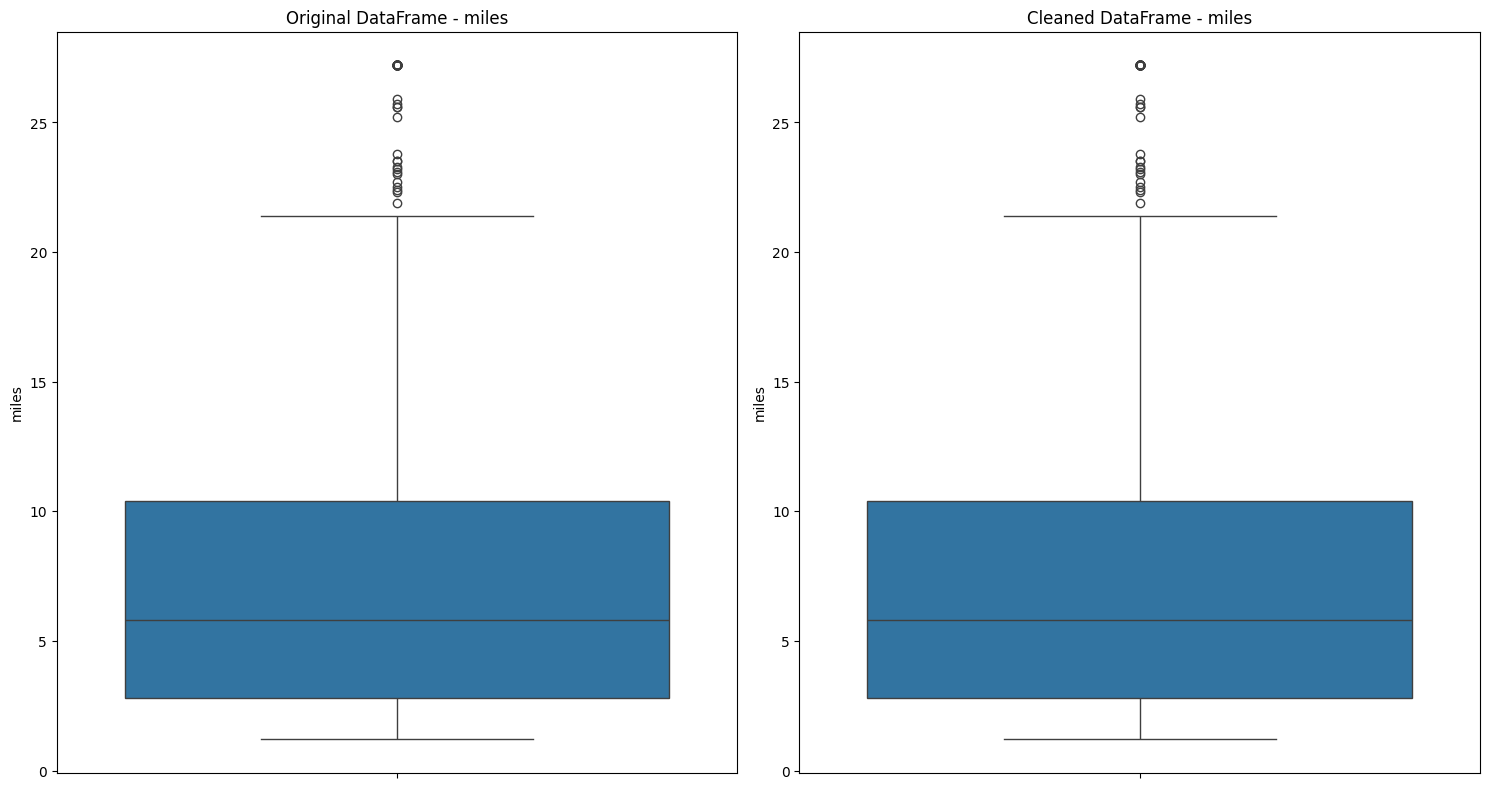

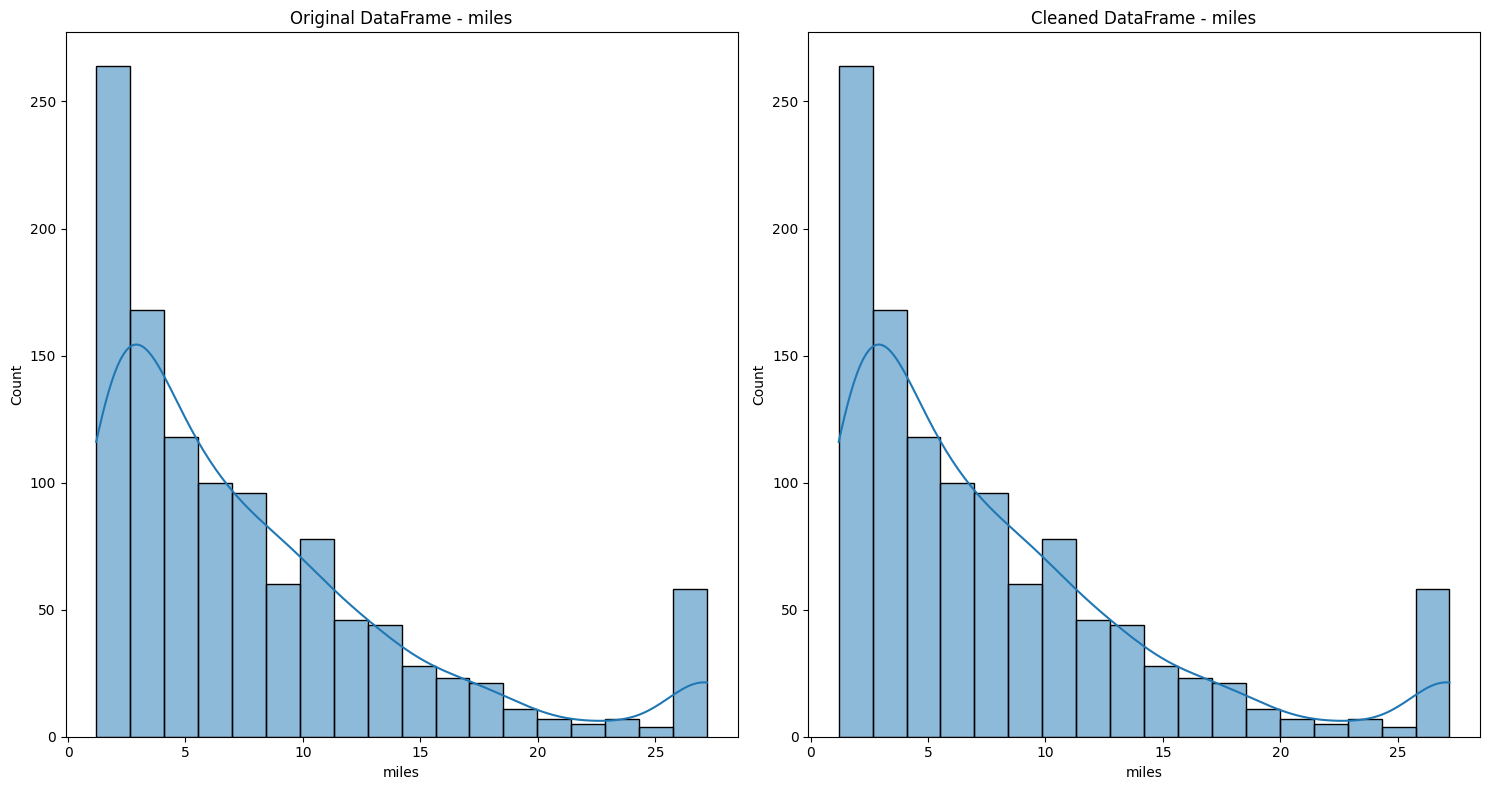


Analyzing column: month_code


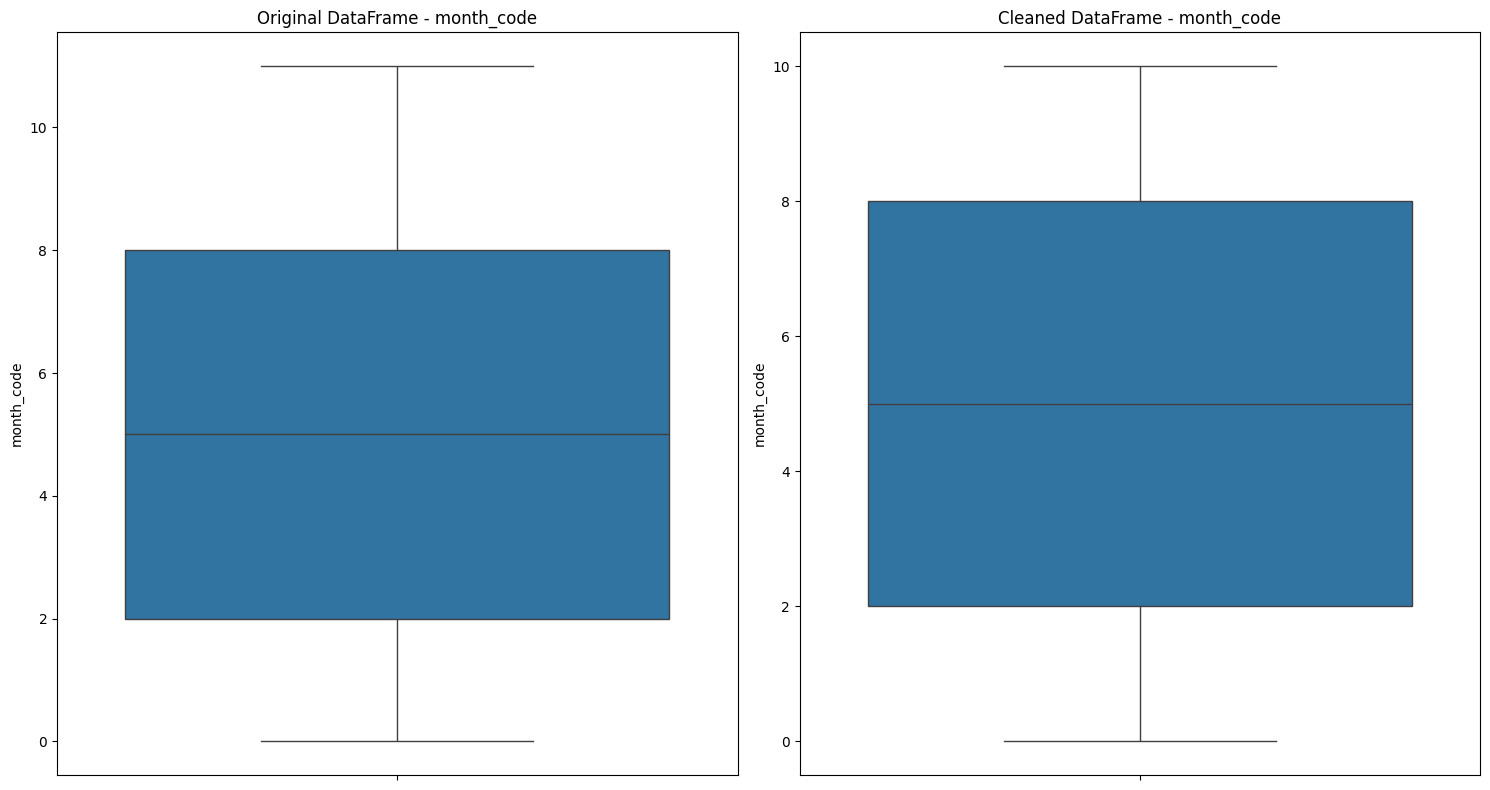

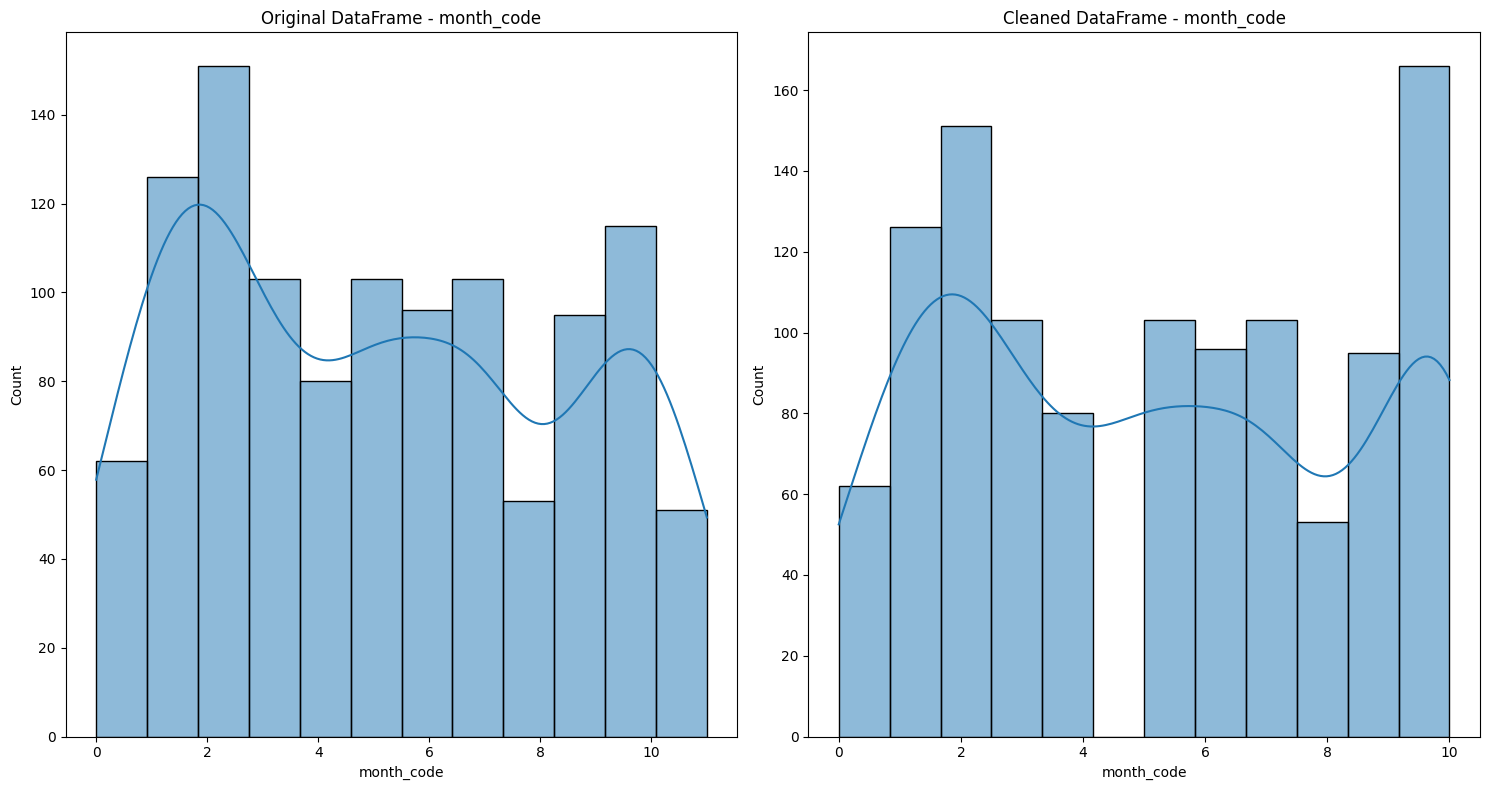


Analyzing column: purpose_Airport/Travel


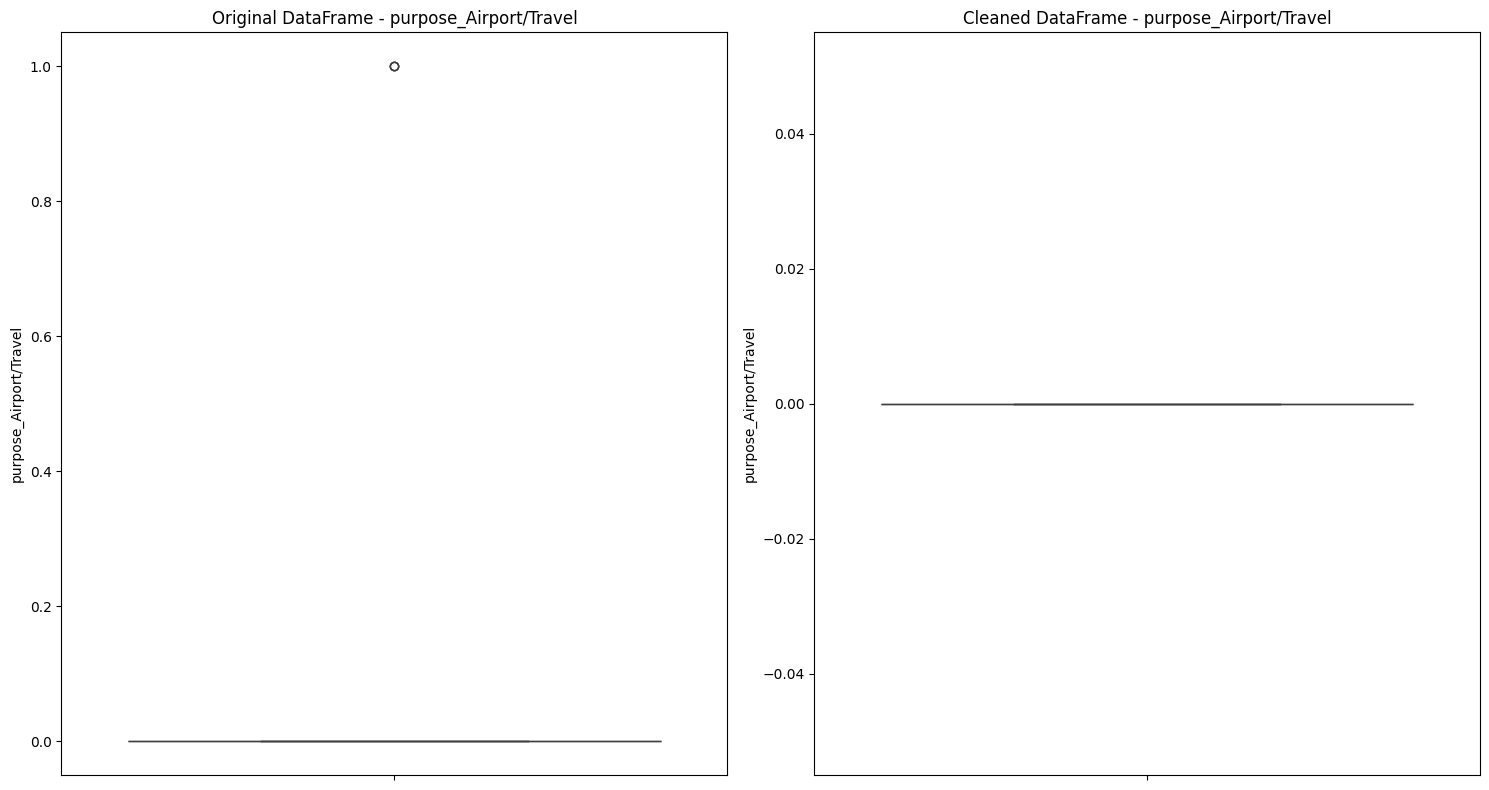

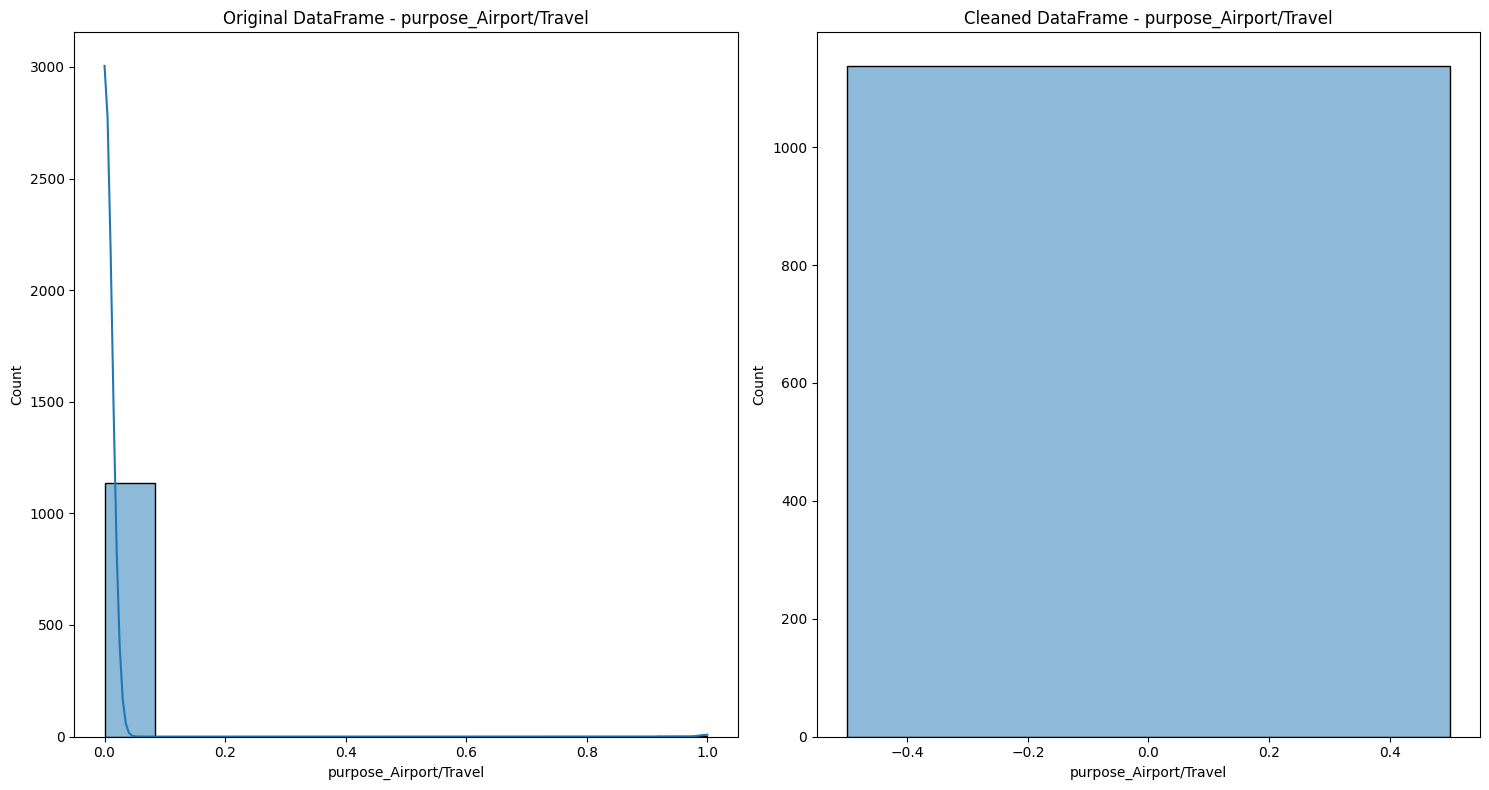


Analyzing column: purpose_Between Offices


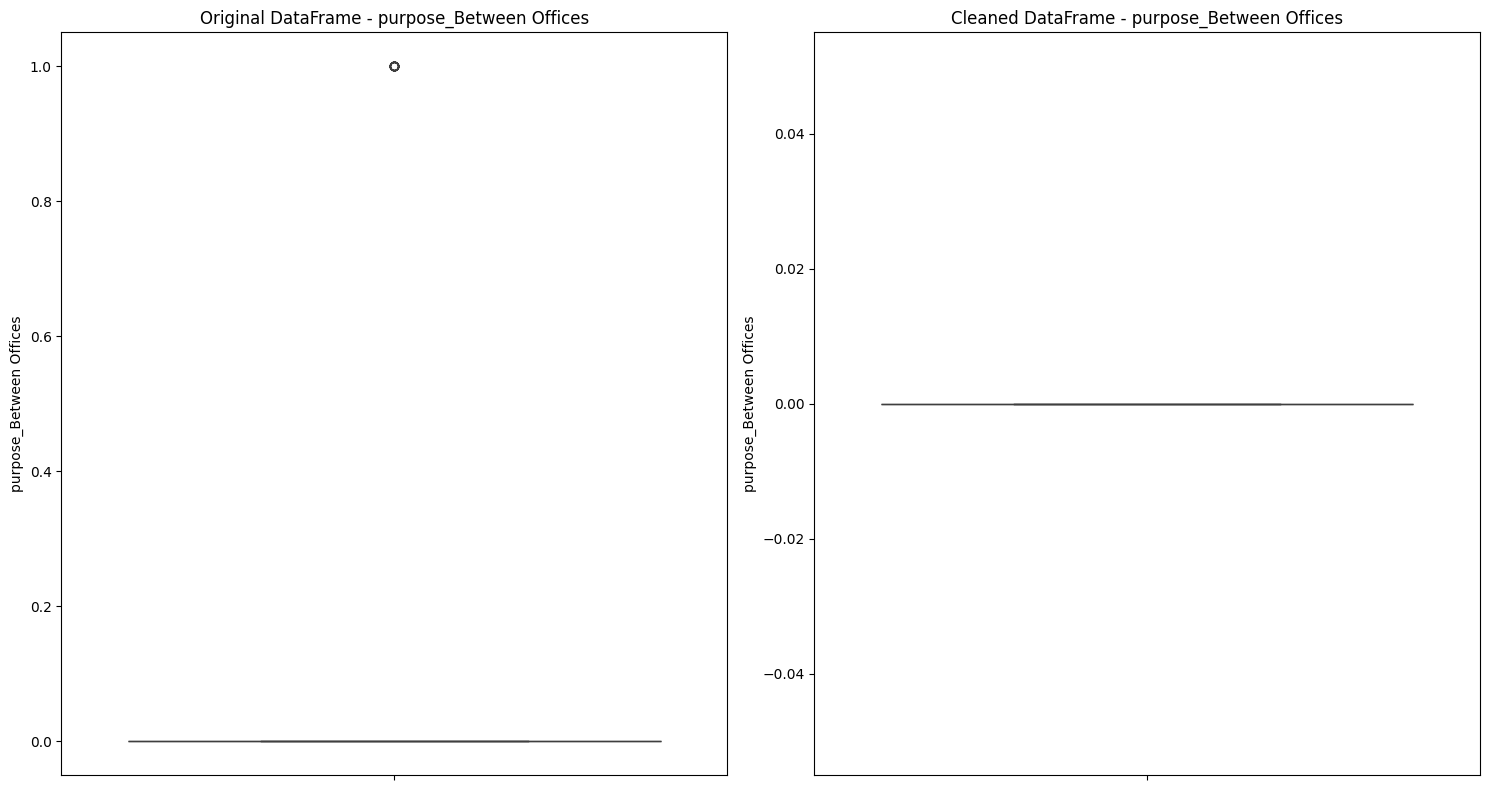

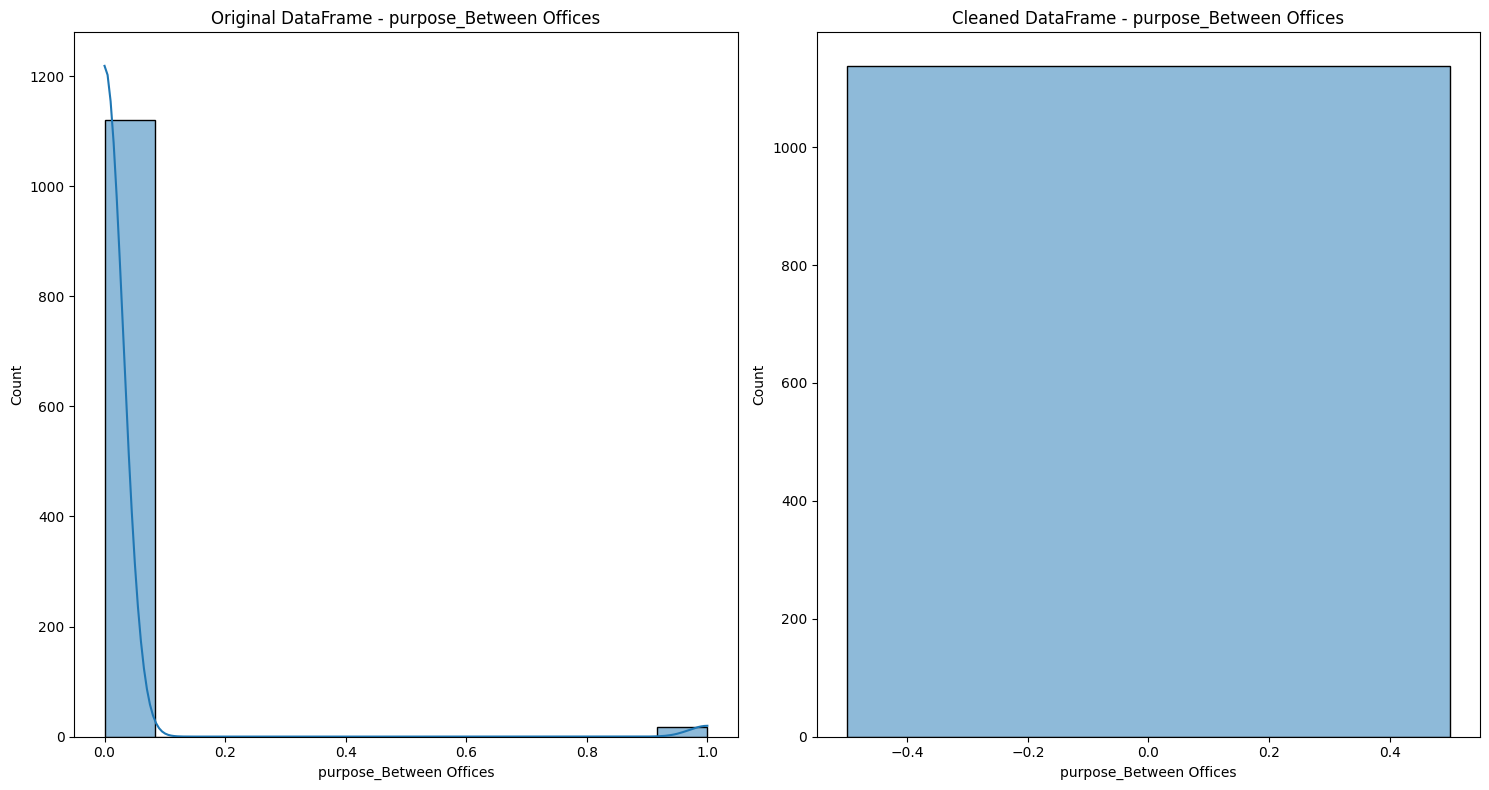


Analyzing column: purpose_Charity ($)


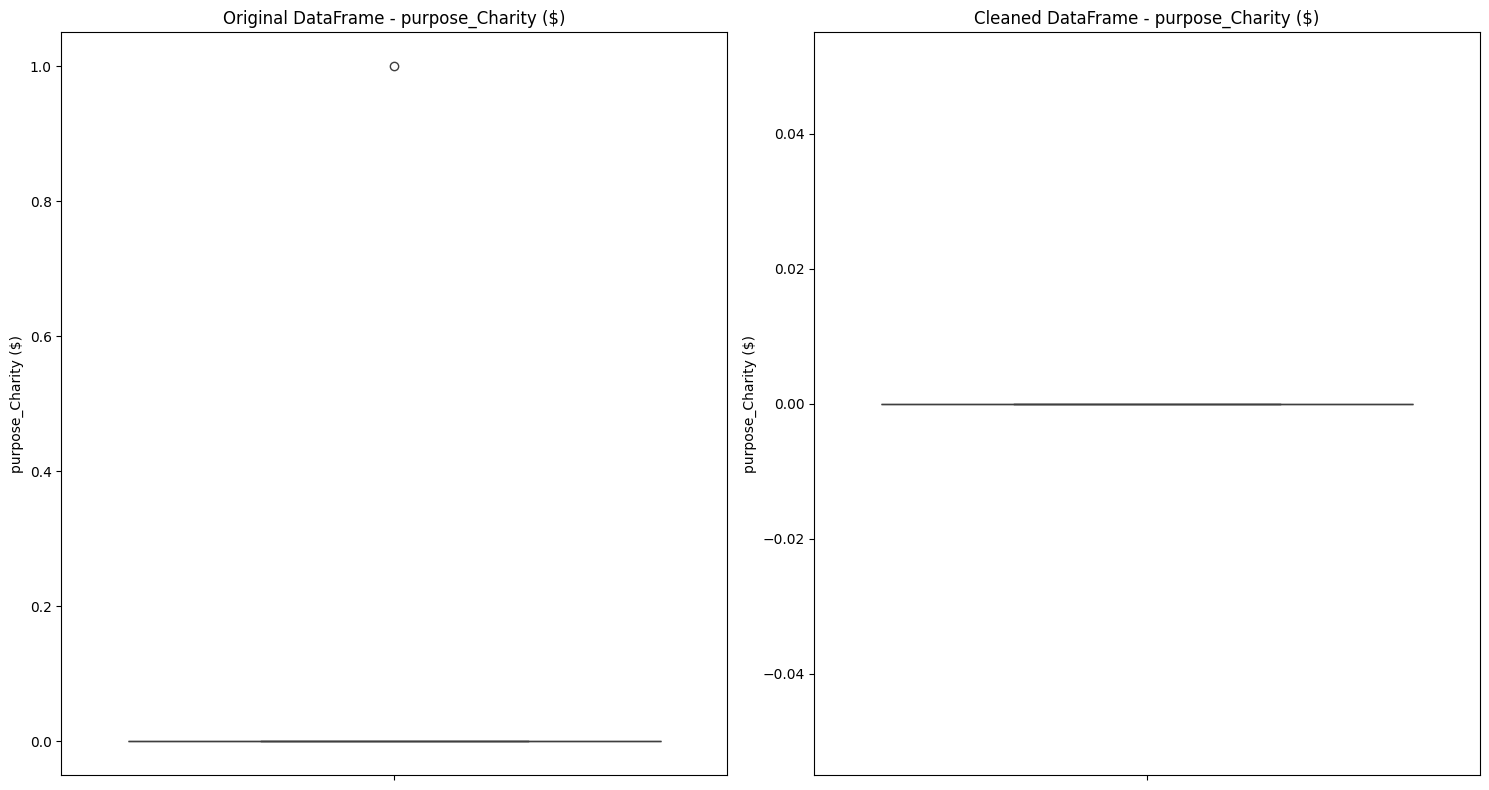

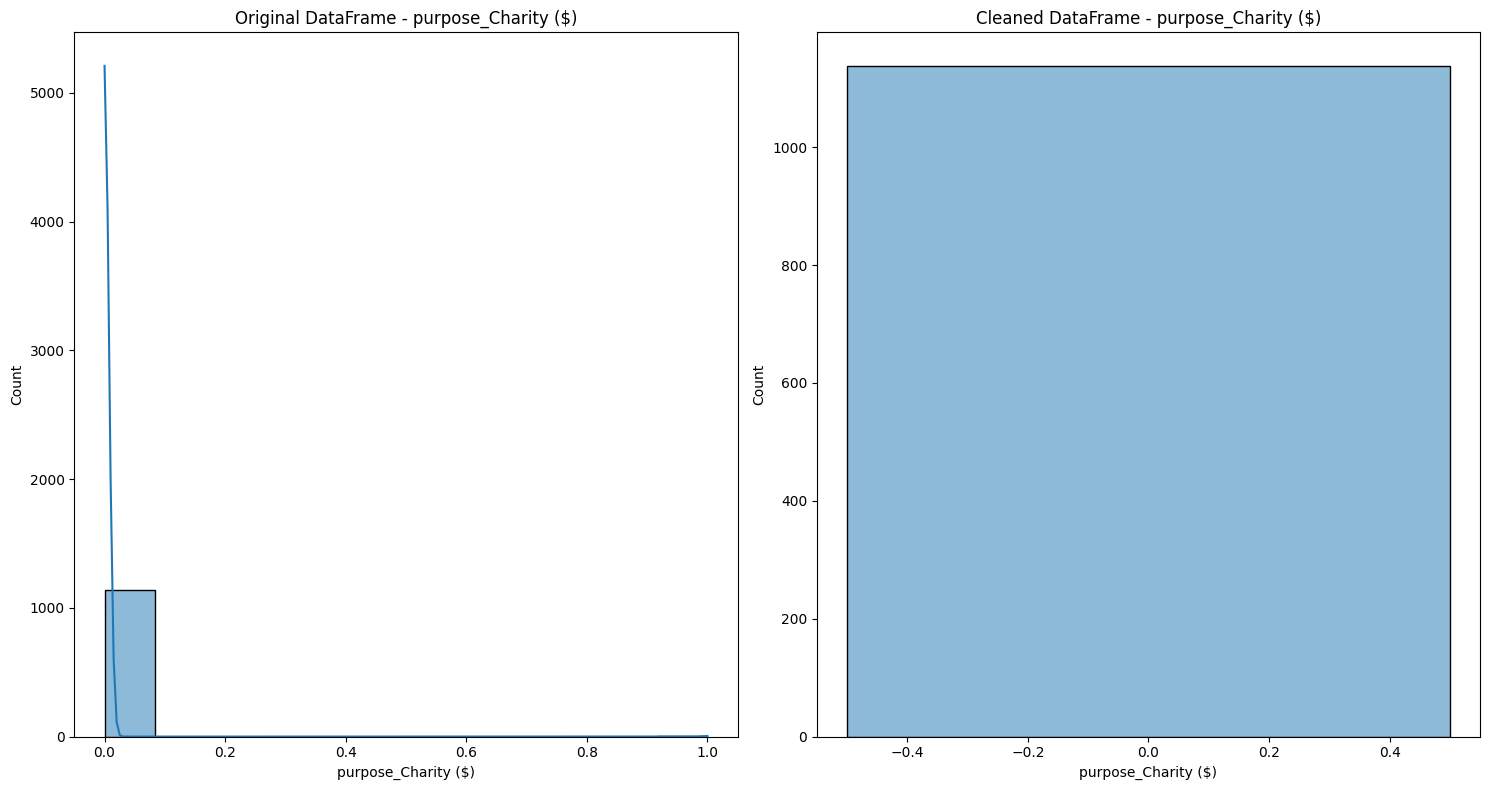


Analyzing column: purpose_Commute


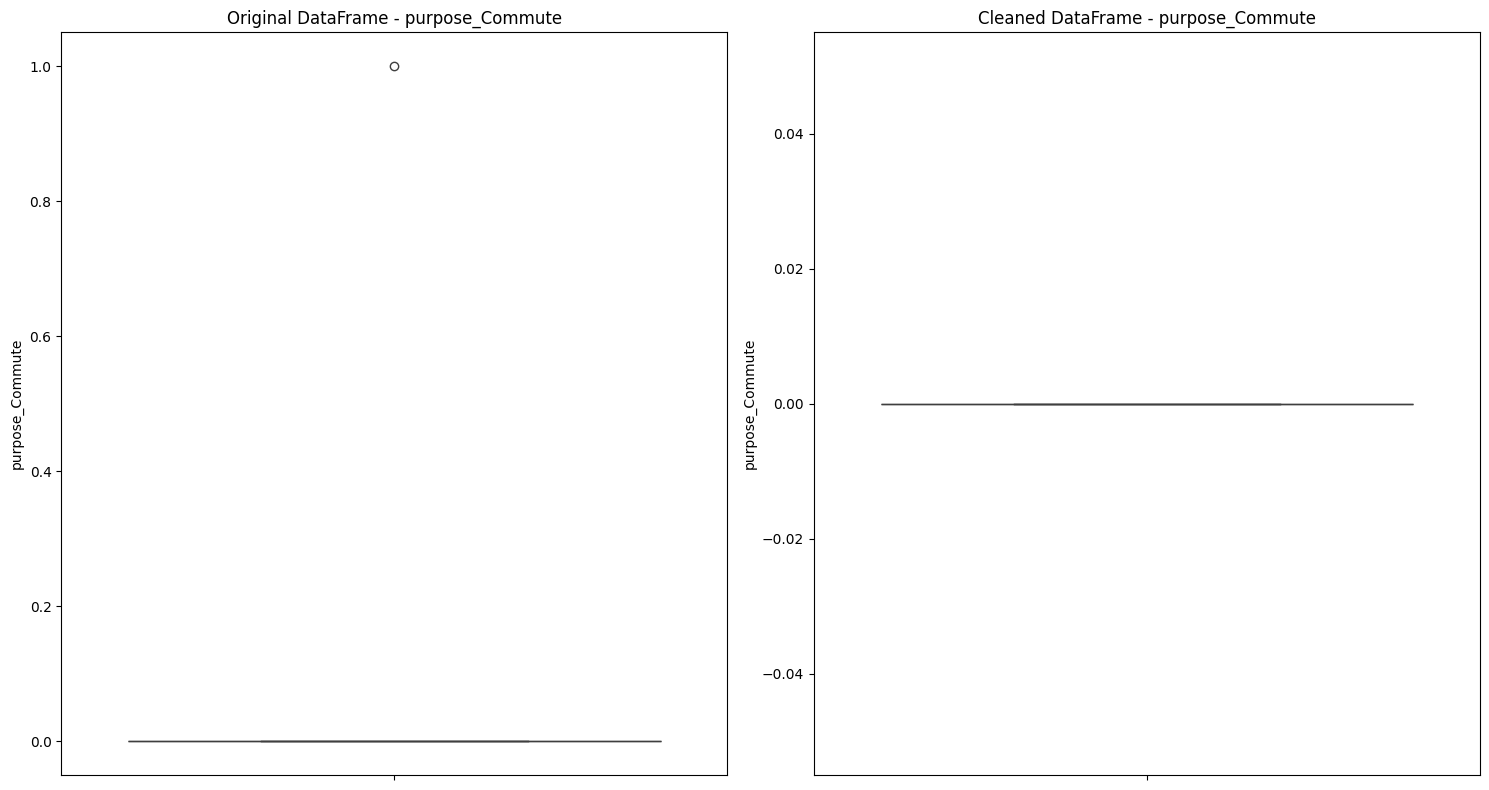

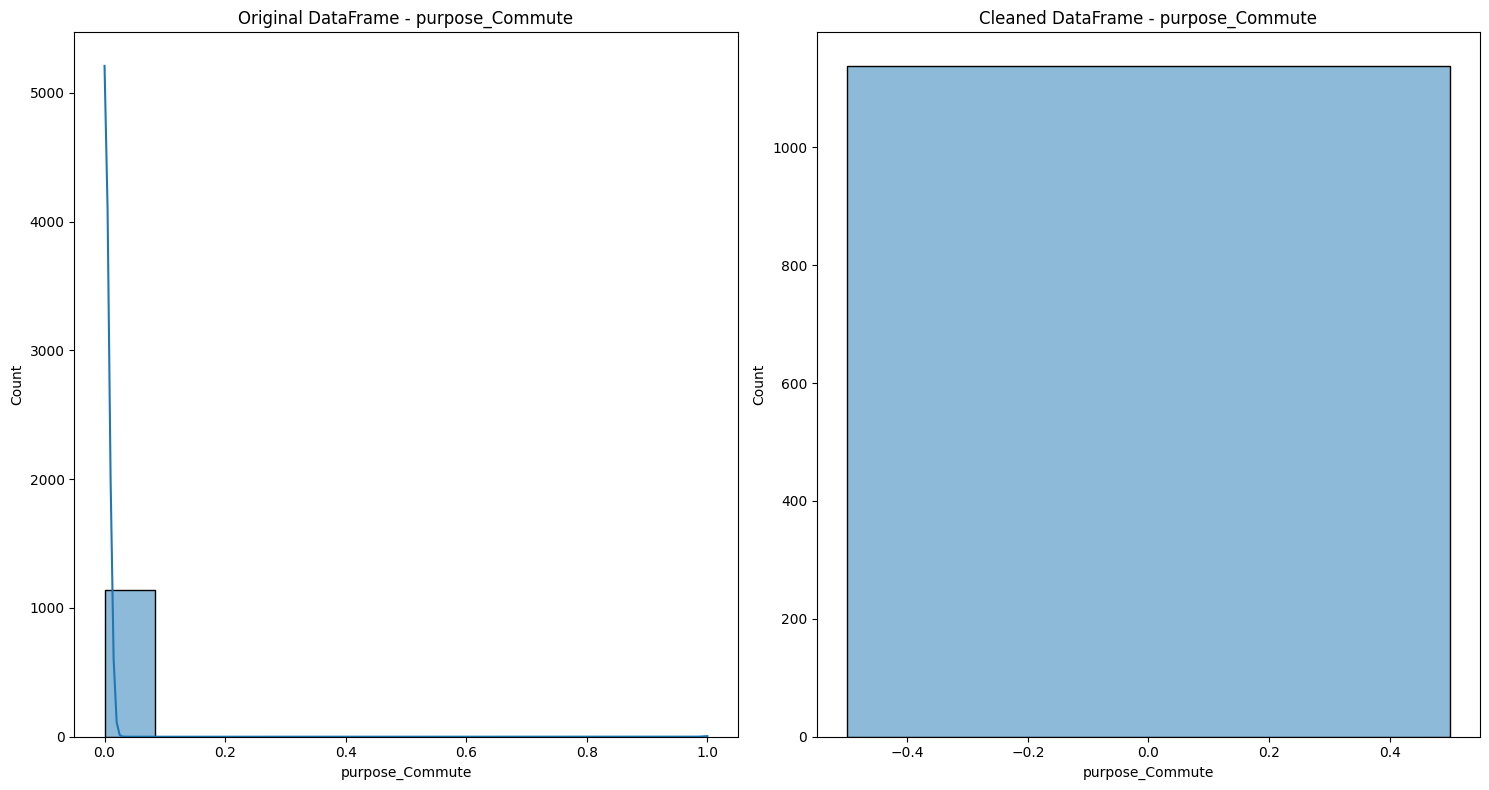


Analyzing column: purpose_Customer Visit


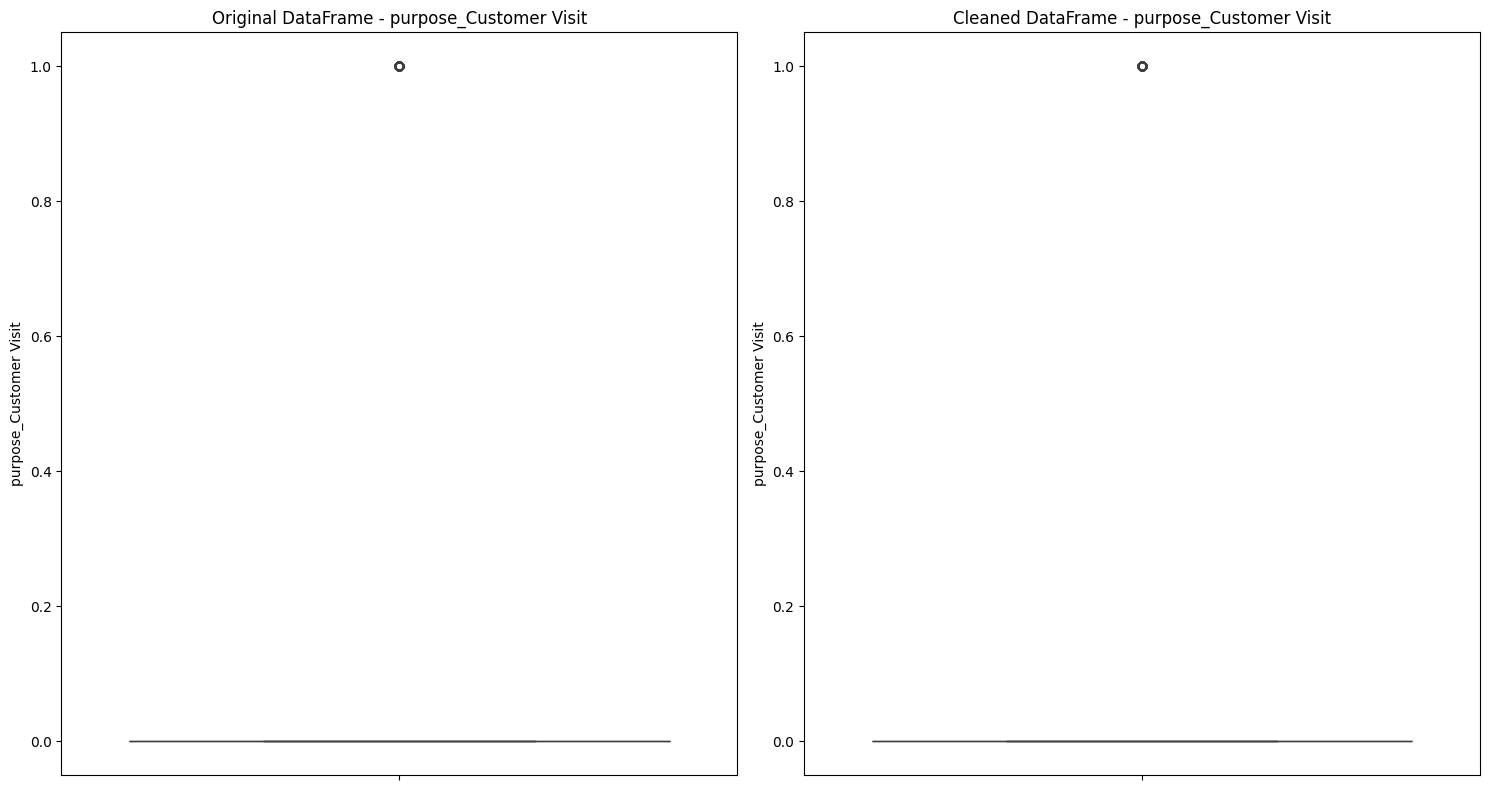

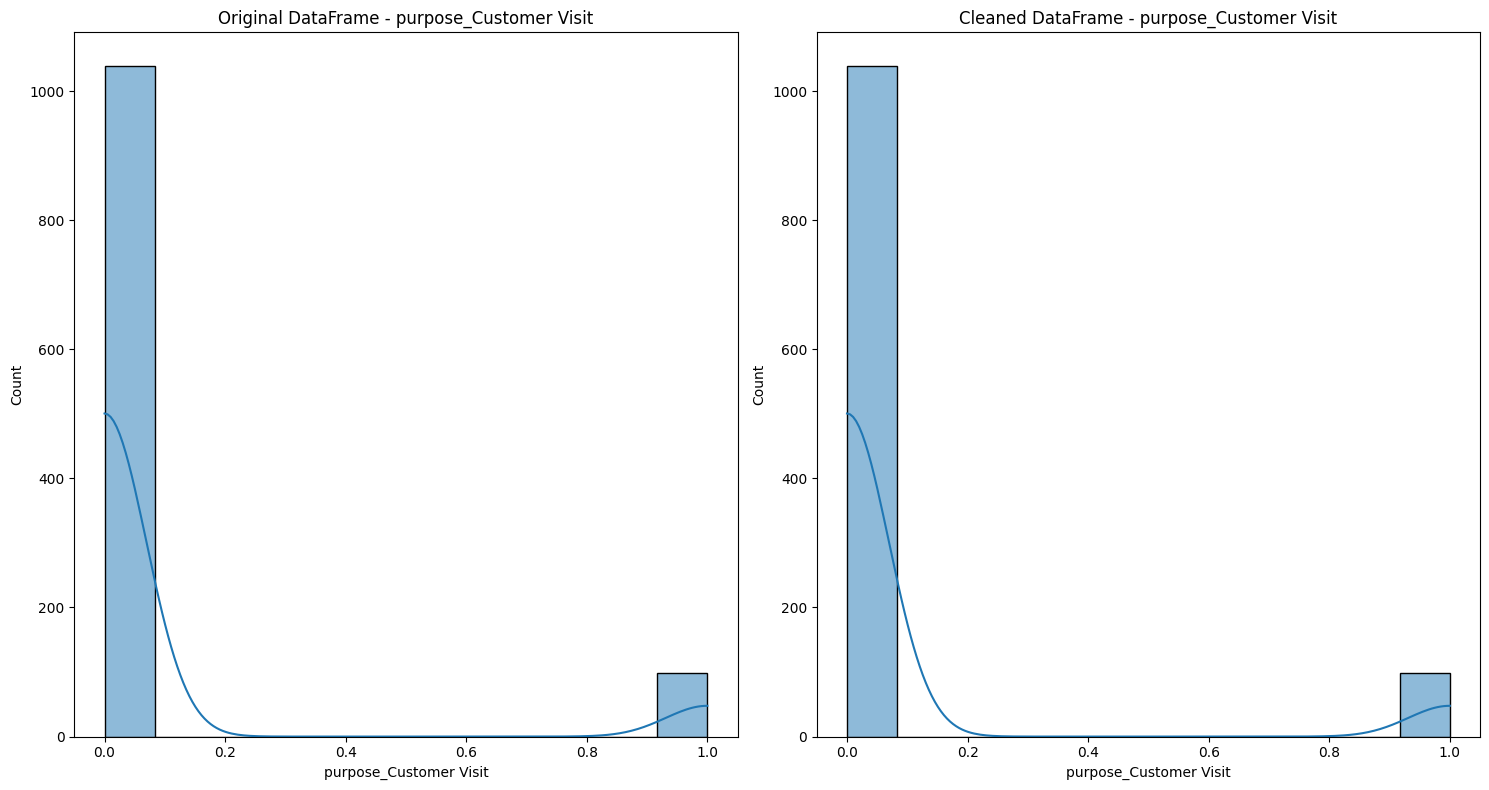


Analyzing column: purpose_Errand/Supplies


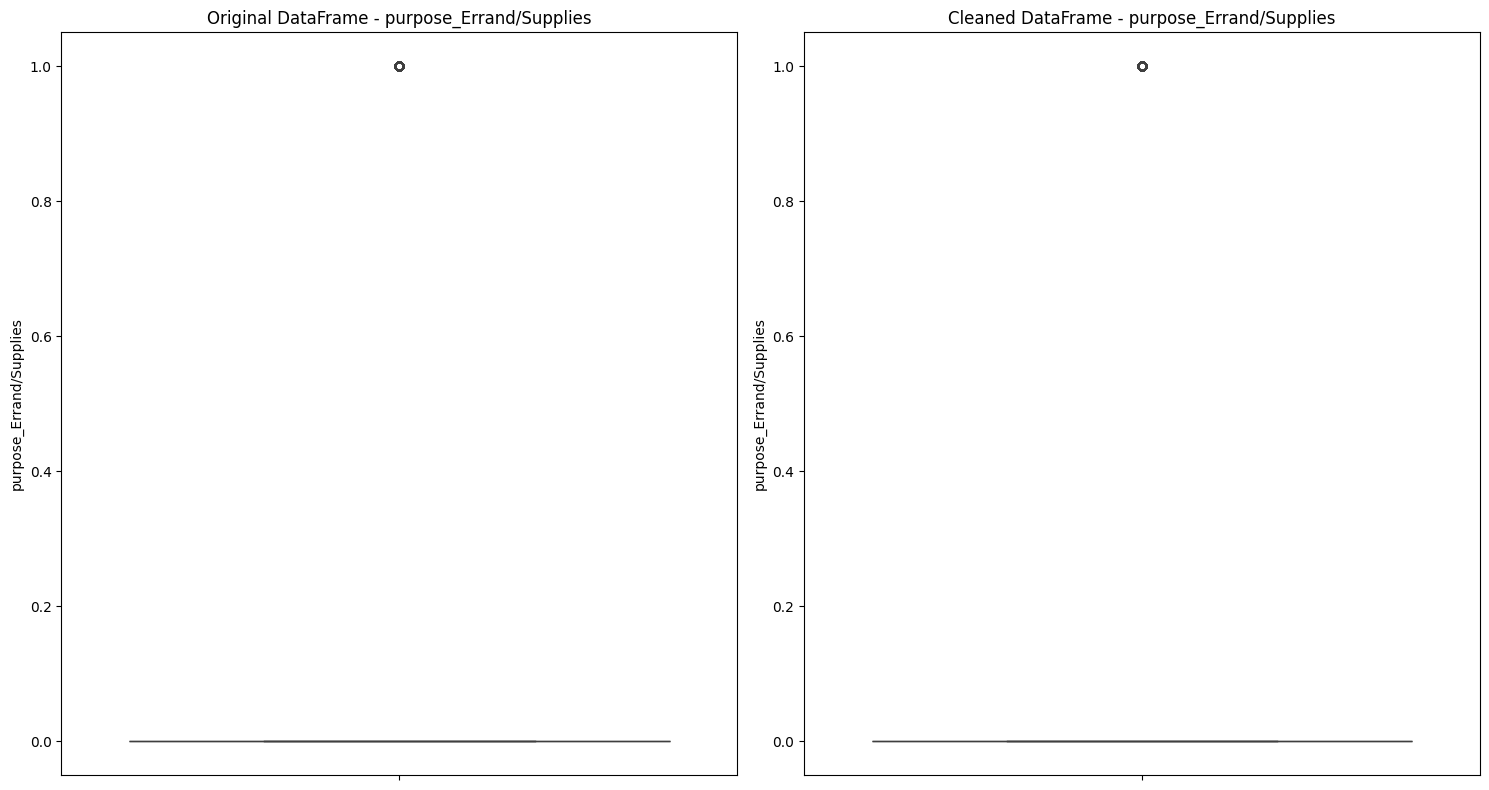

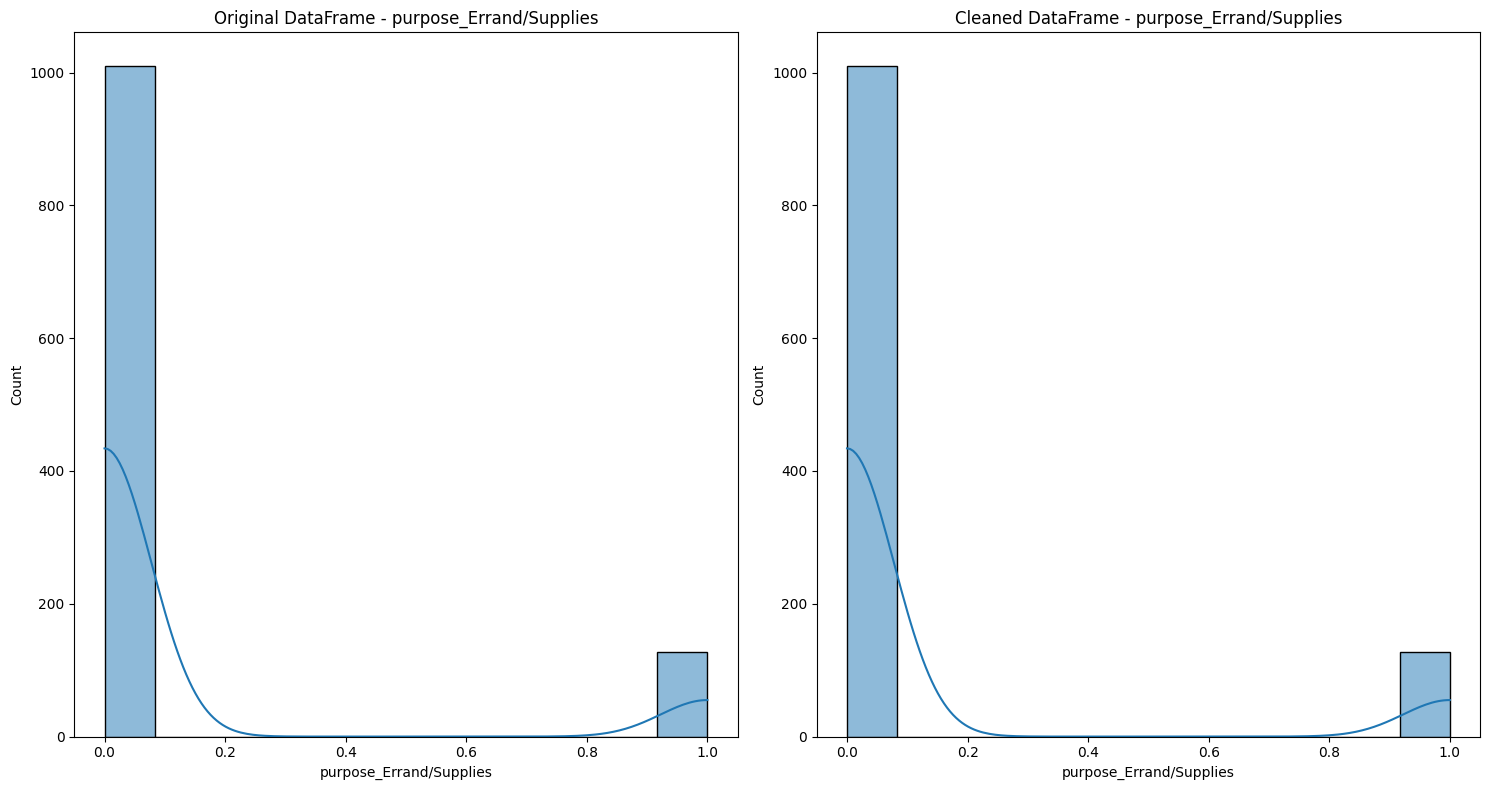


Analyzing column: purpose_Meal/Entertain


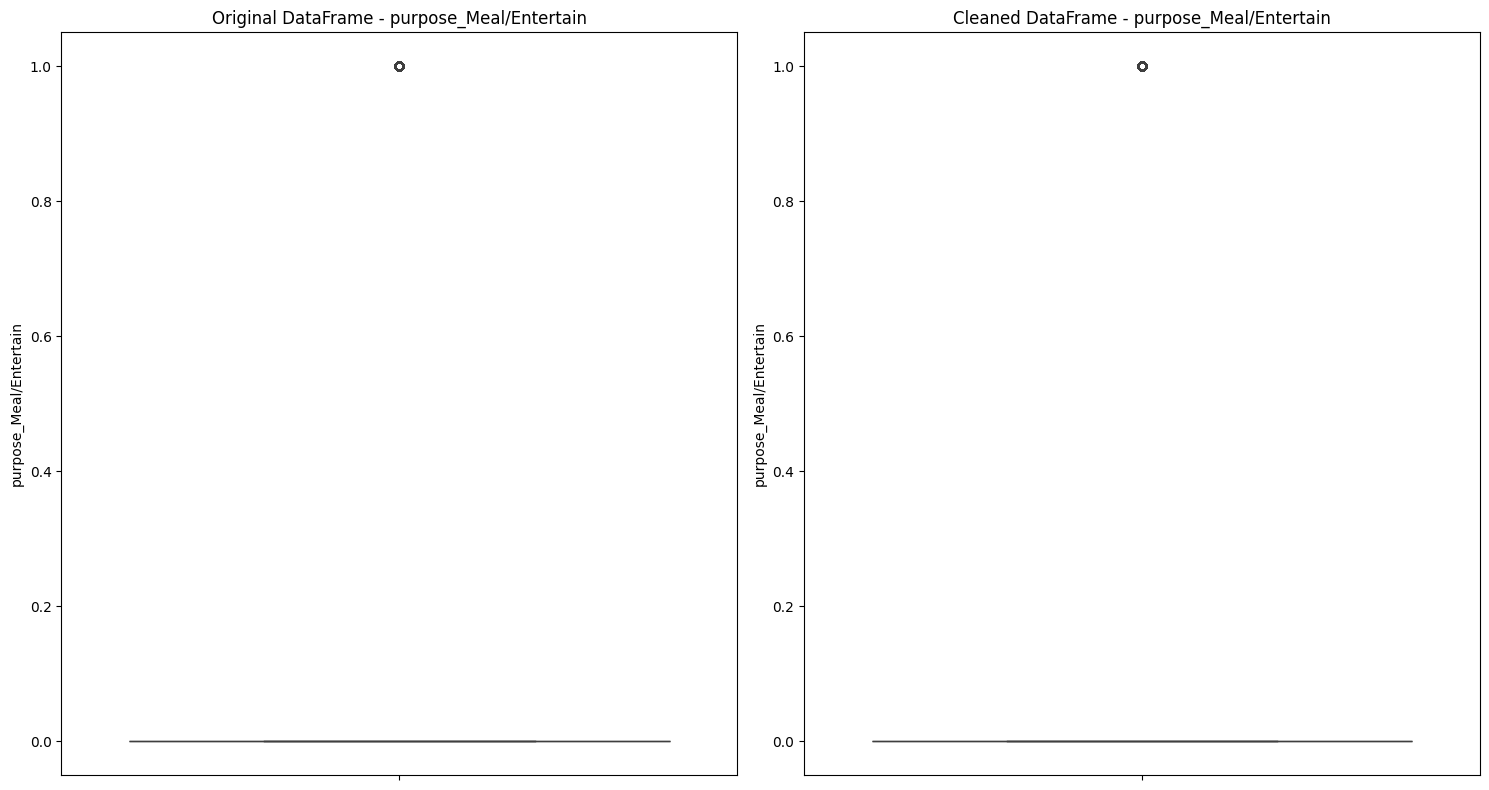

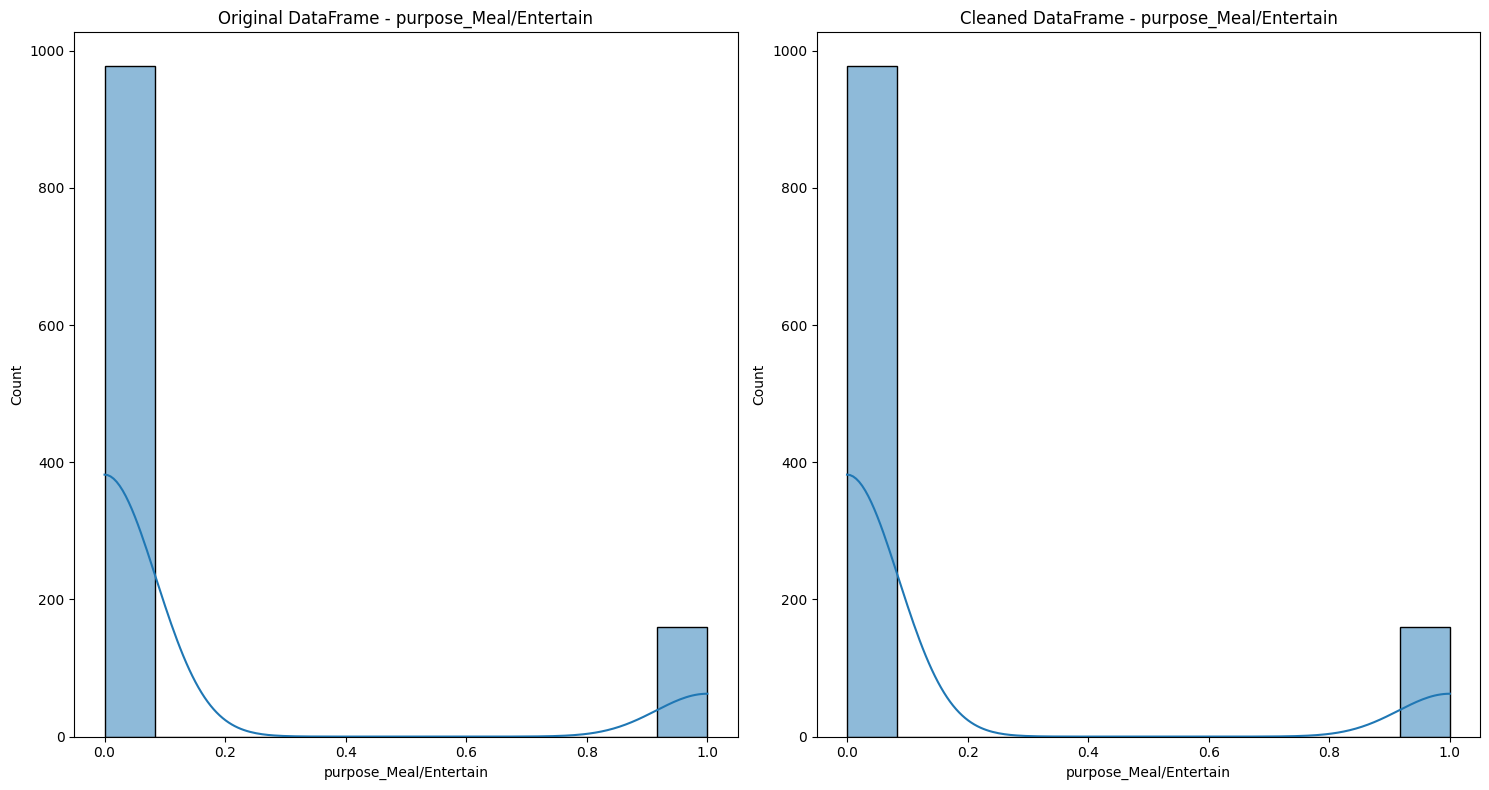


Analyzing column: purpose_Meeting


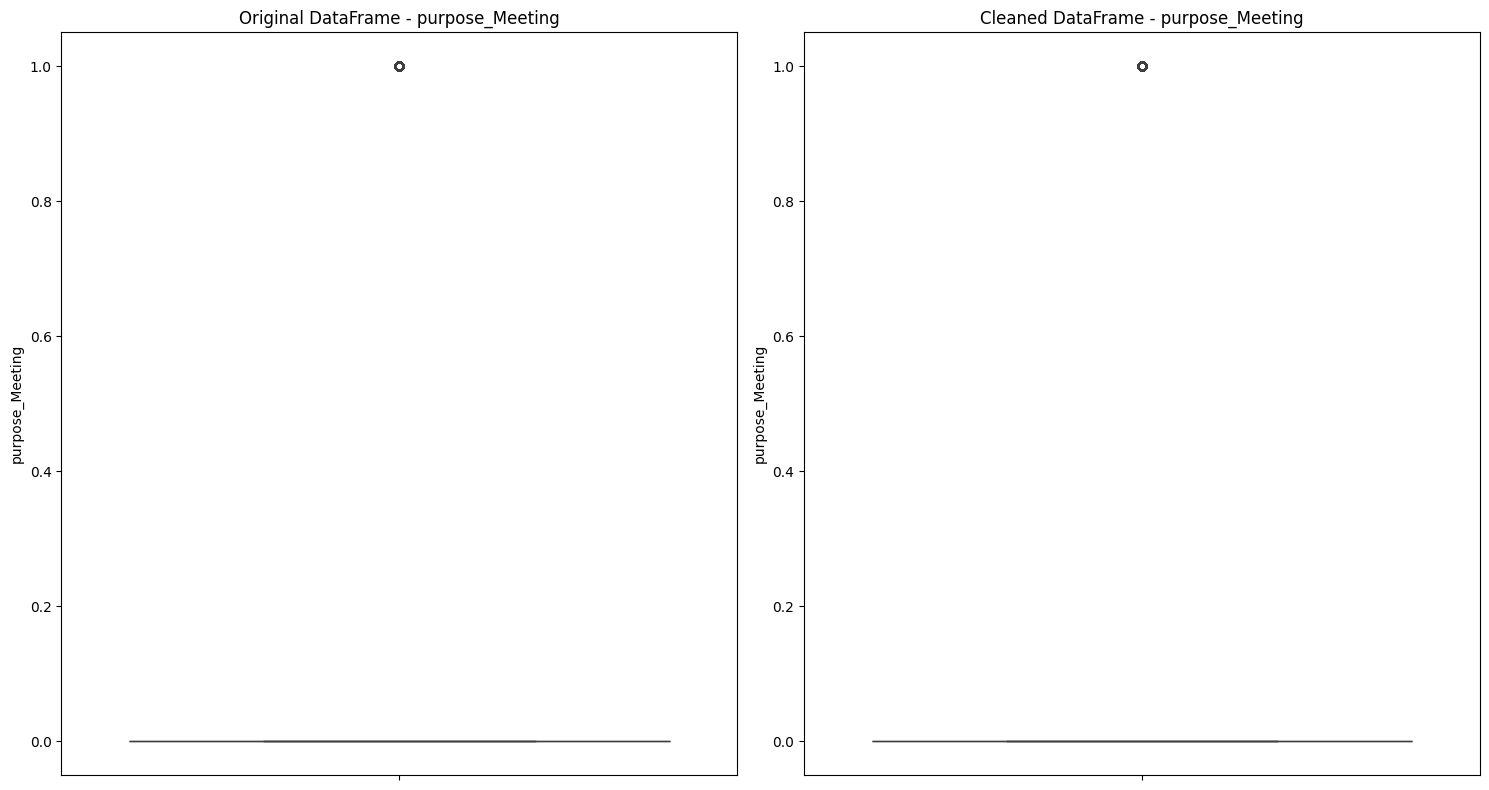

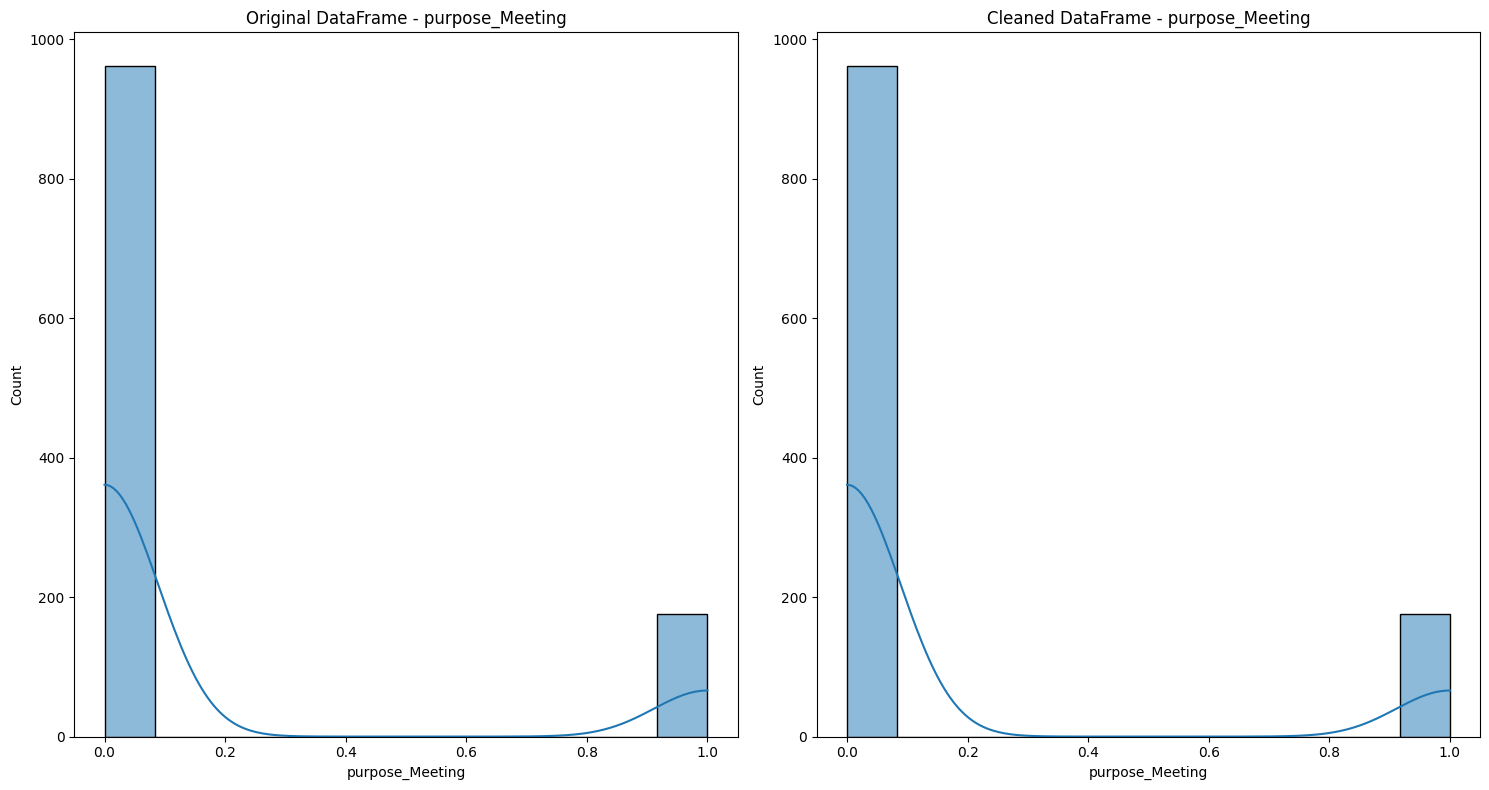


Analyzing column: purpose_Misc


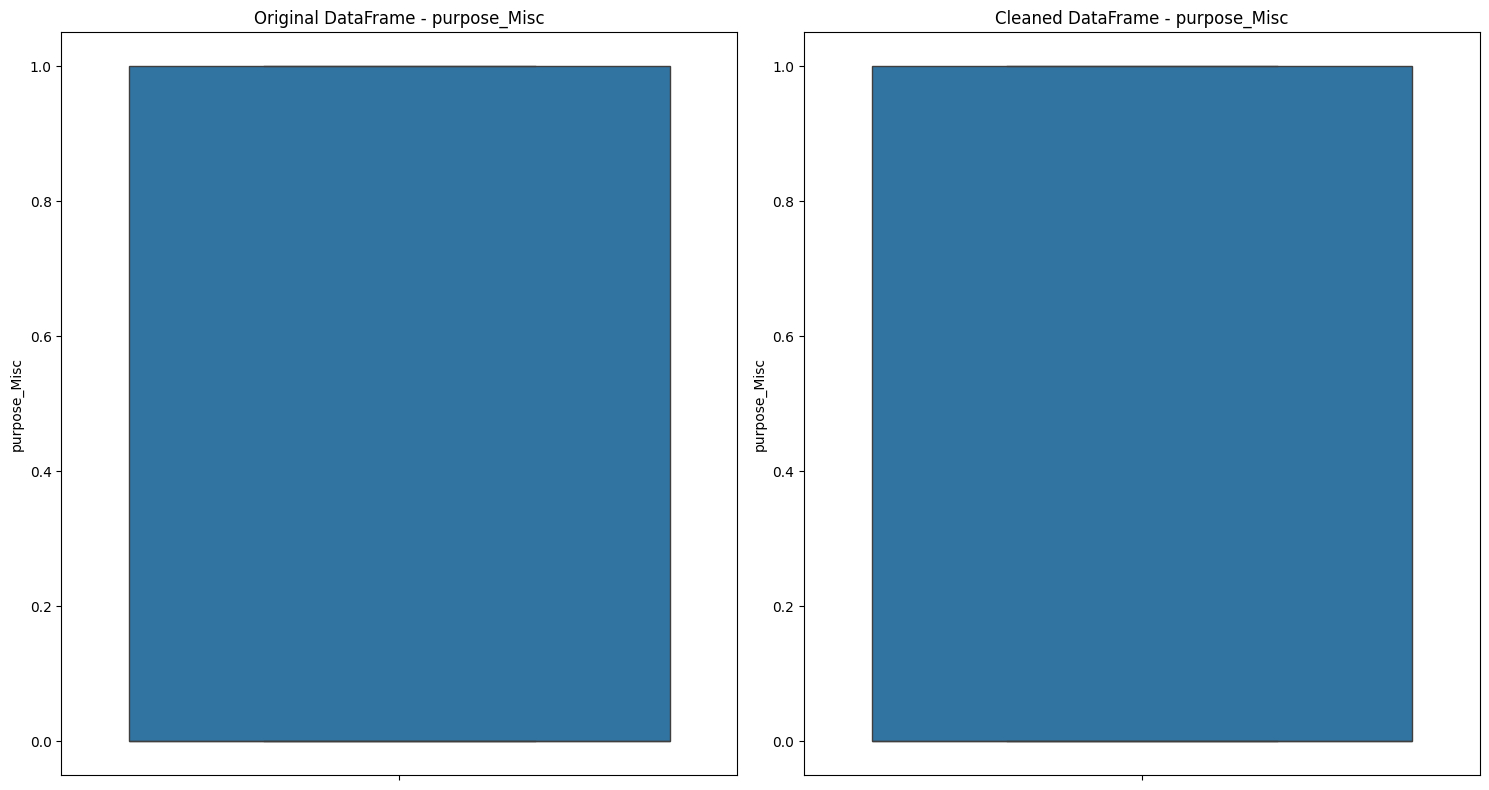

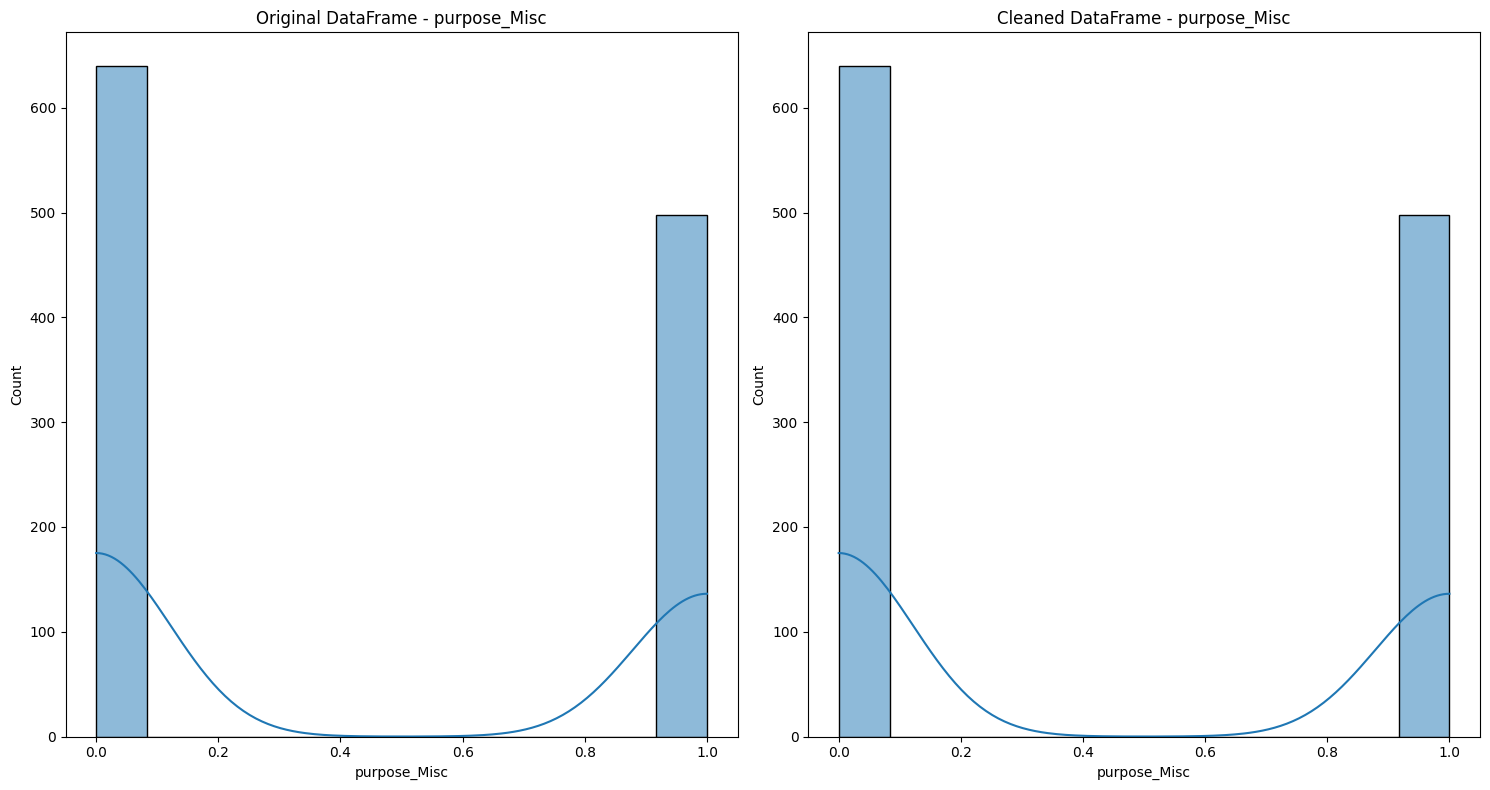


Analyzing column: purpose_Moving


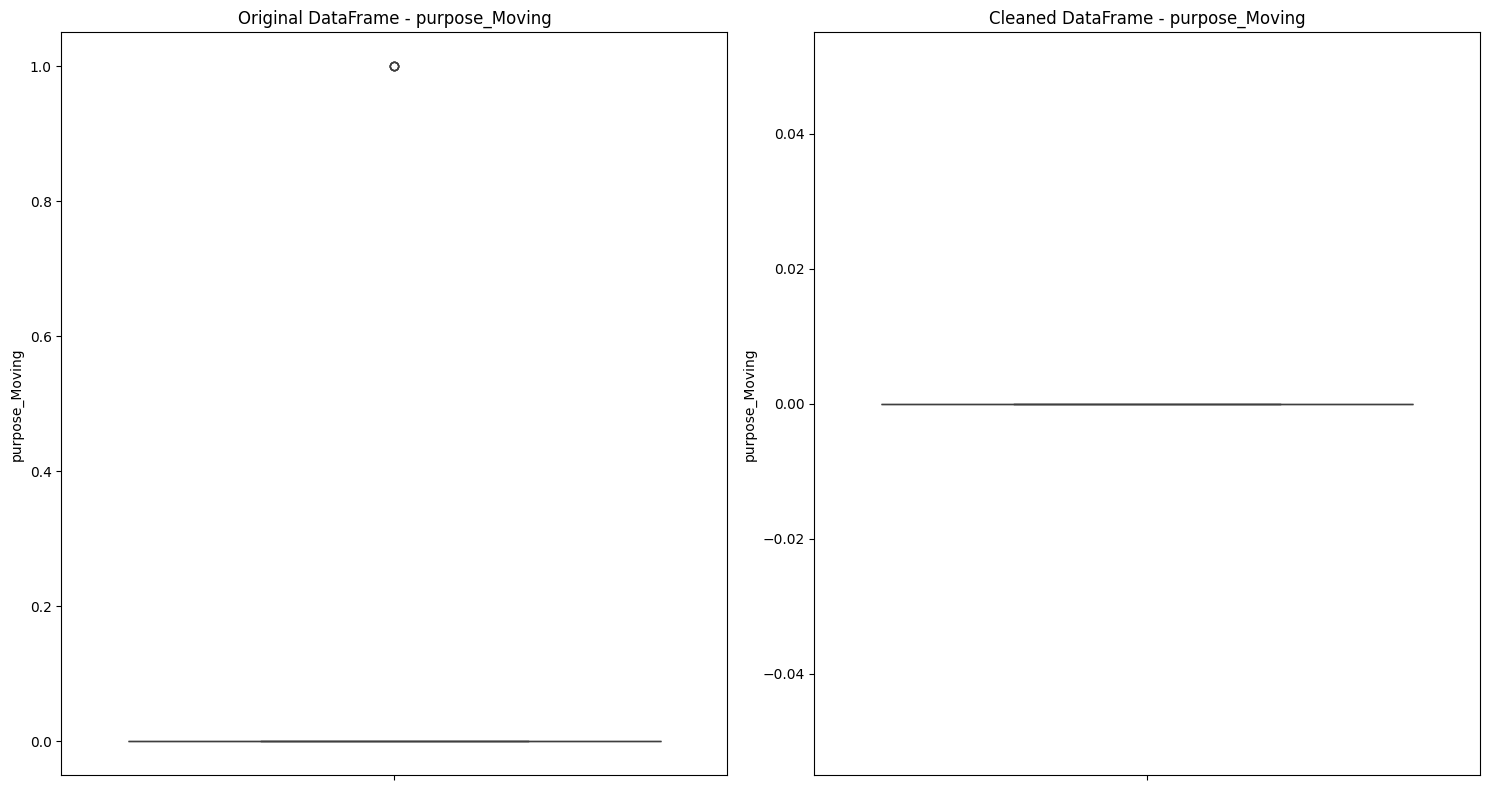

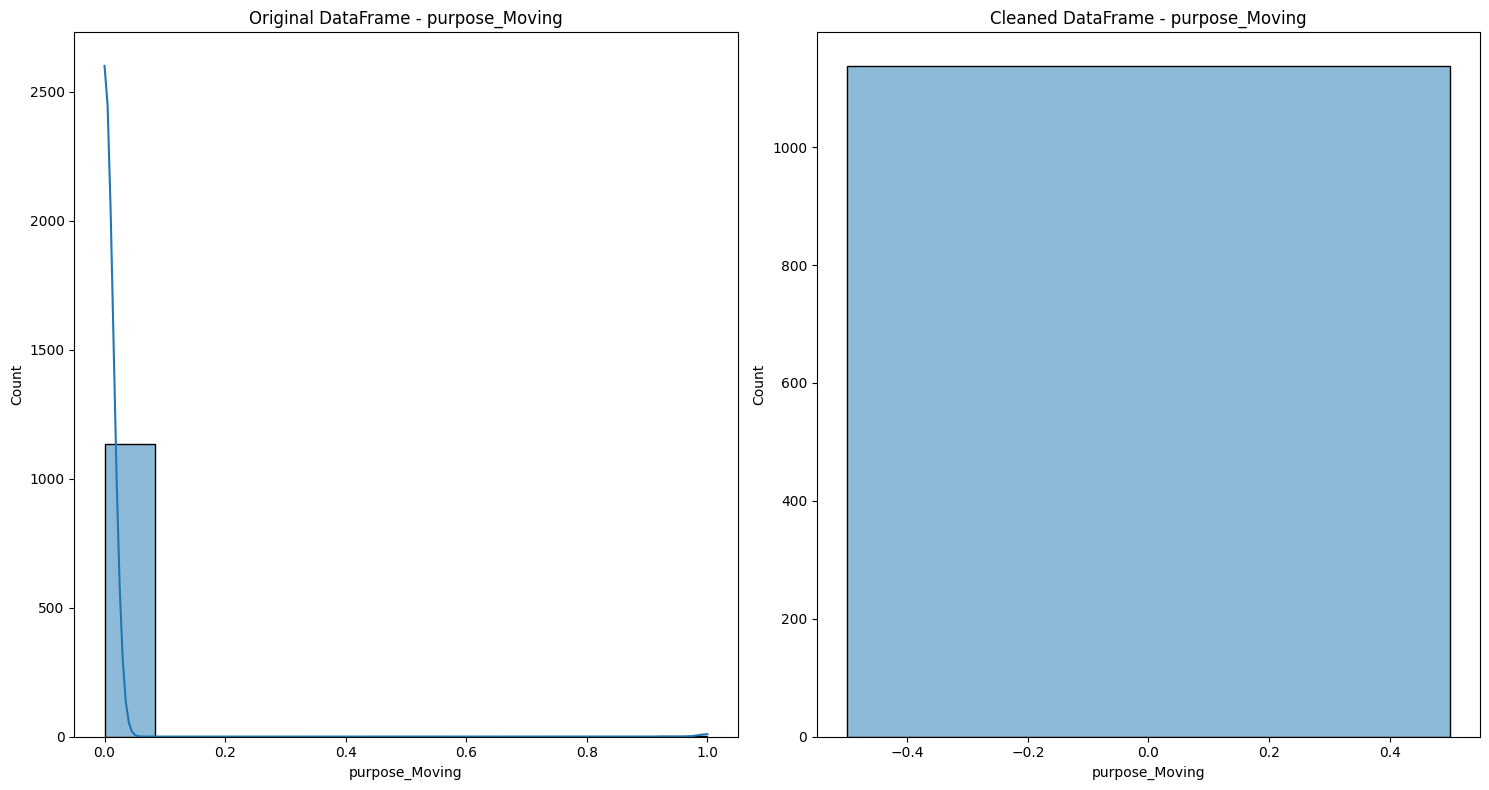


Analyzing column: purpose_Temporary Site


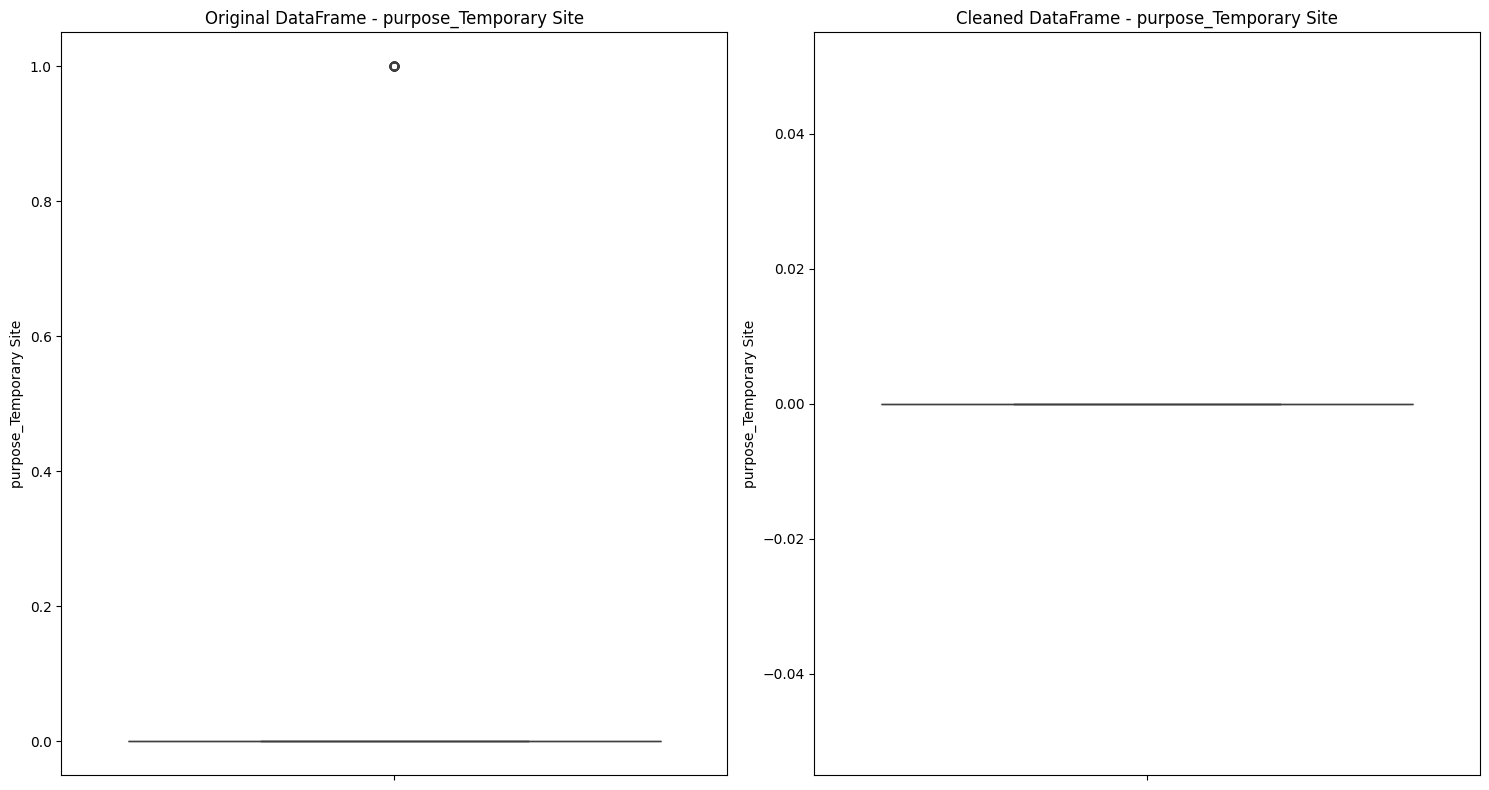

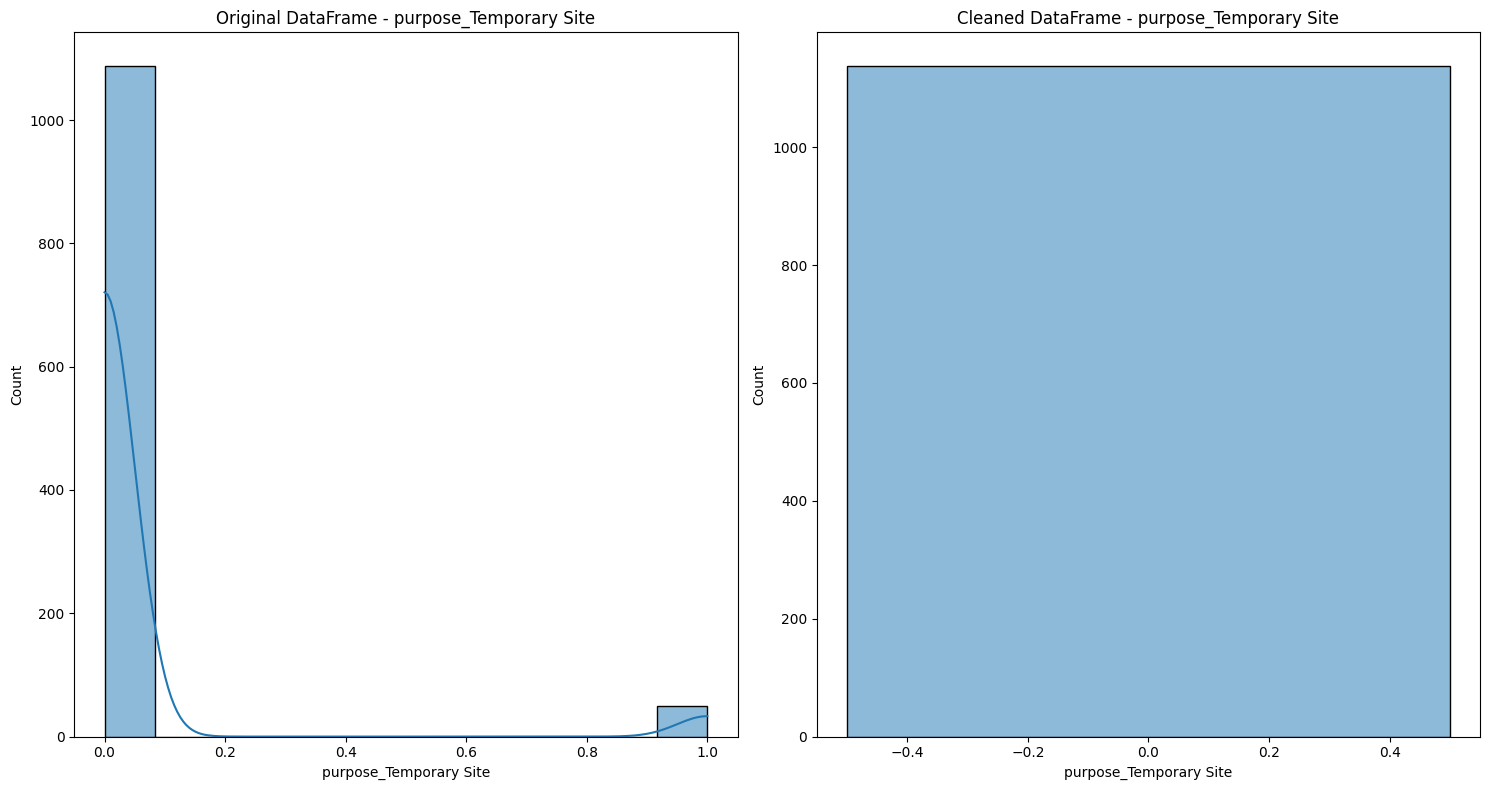


Analyzing column: rank_by_total_distance


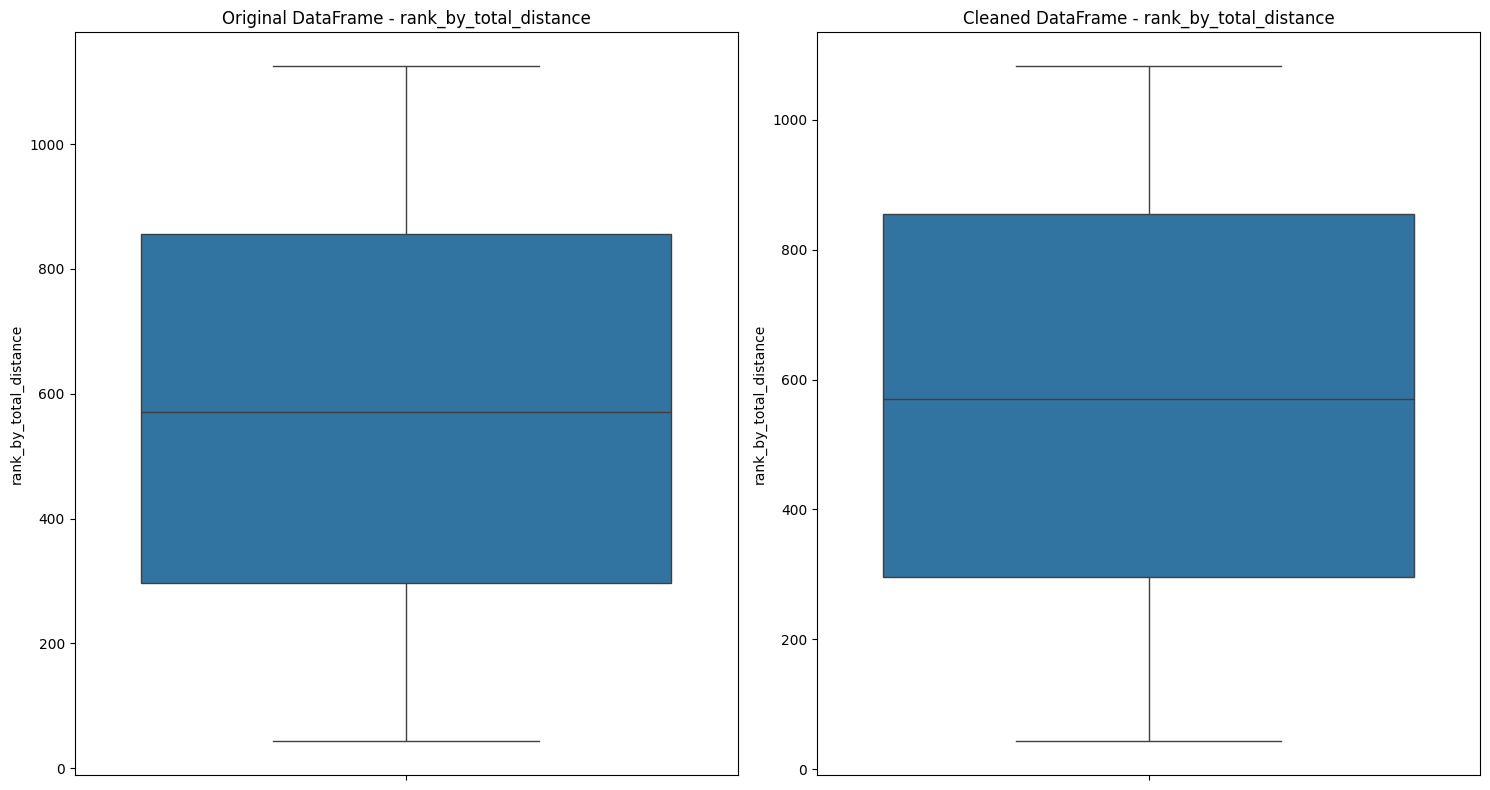

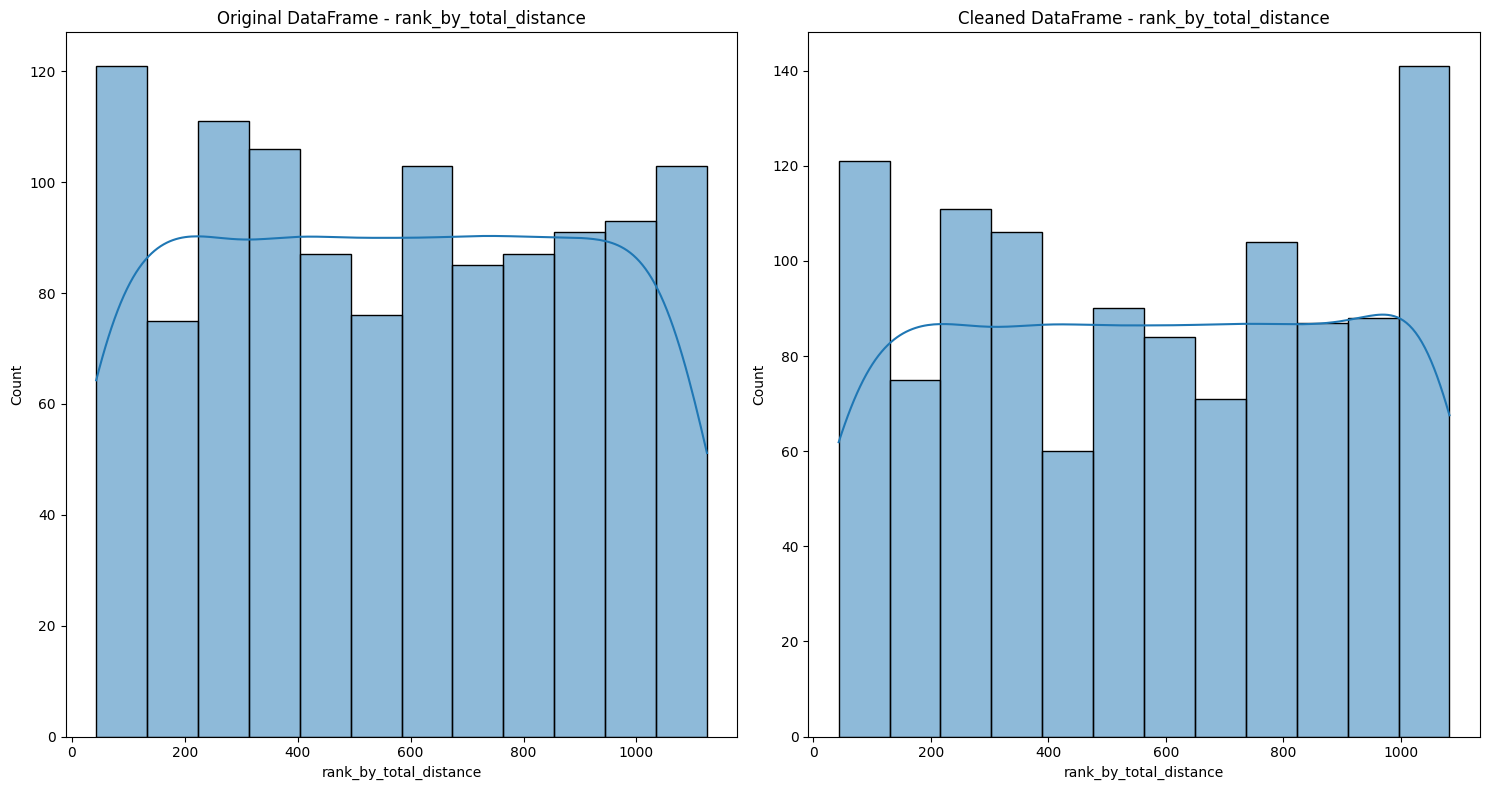


Analyzing column: rank_by_frequency


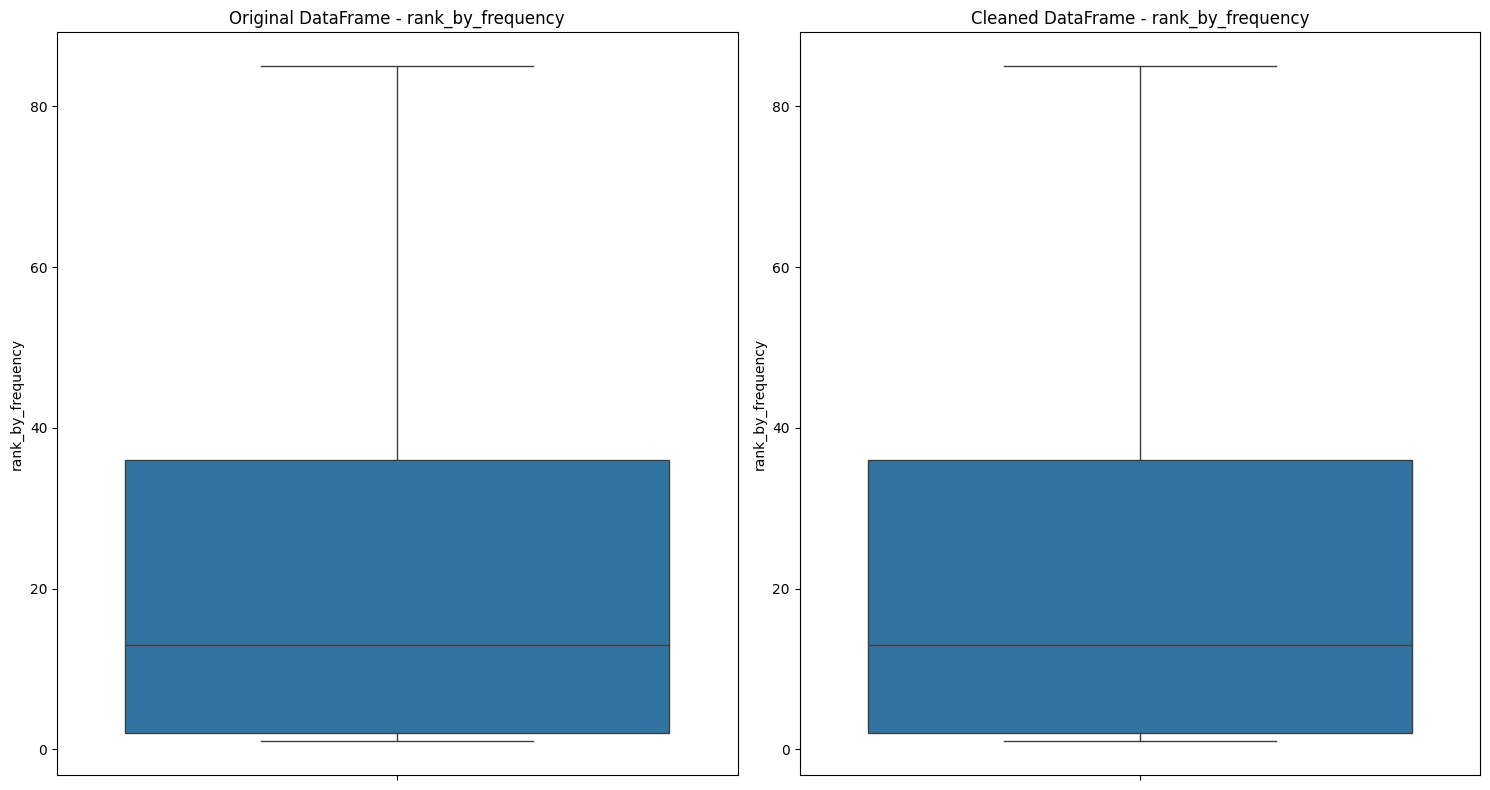

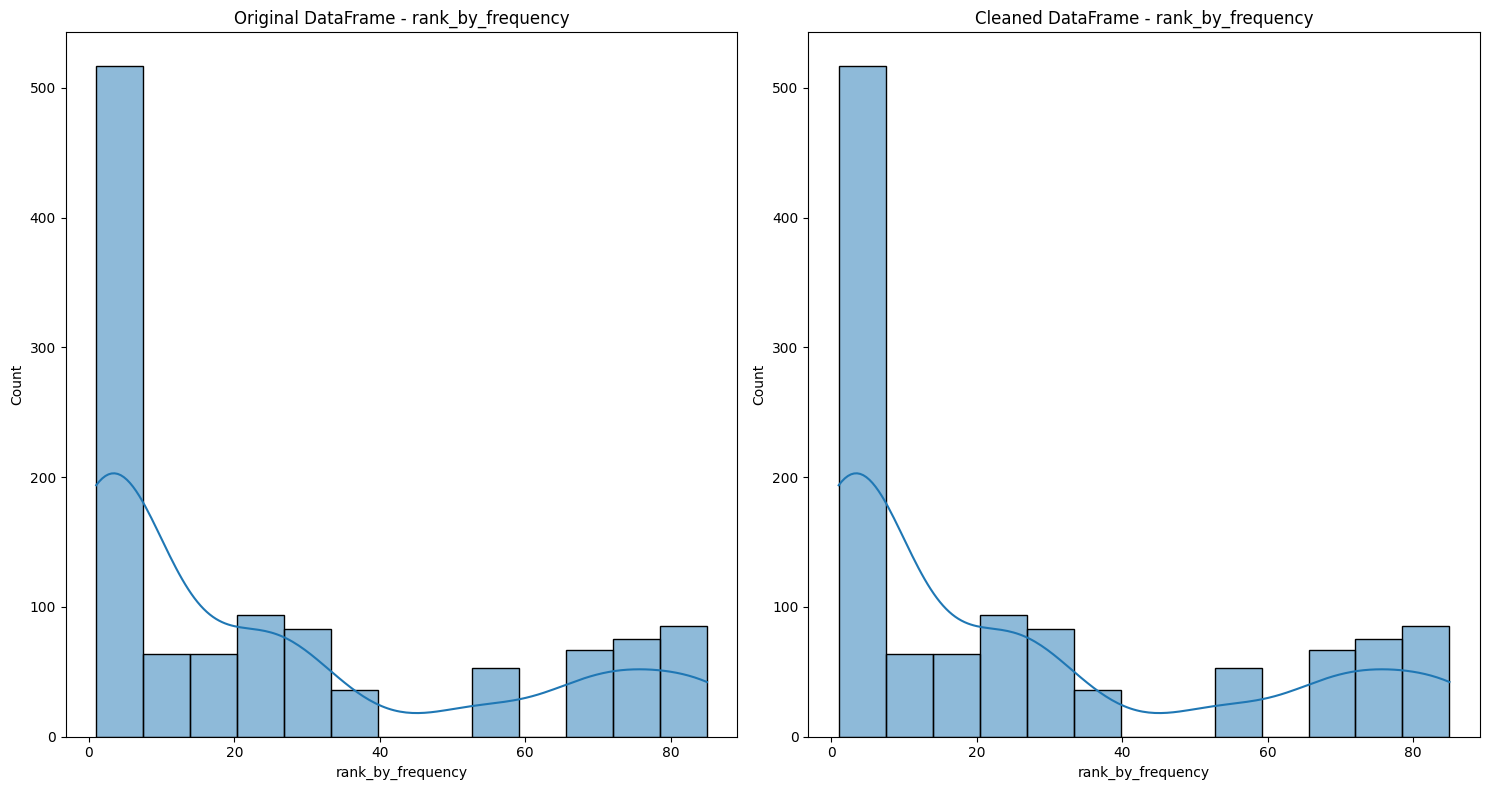

In [ ]:
# Check tail and normality
rak.classify_tail(df.copy())
rak.check_normality(df.copy())
# miles is light tailes and not normal: will winsorize
df_cleaned=pd.DataFrame()
df_cleaned=rak.winsorize_numeric_columns(df.copy())
# Visualise the data before and after winsorize
exclude_list=[]
rak.compare_distributions(df.copy(), df_cleaned.copy(),exclude_list)
# Accept the winsorize data
df=df_cleaned
# Save df to gdrive

## Analysis of fields/aggregates Vs other features
We can build visualisations if we see anything meaningful. What questions they answer

* Avg miles by purpose- How much ppl travel to eat etc
* Max tfc during various day-time slots
* Most imp route- Get head or tail
Describe function: Versatile. Off the bat limites and we have to run indl comd on non-Numeric fds to get details like count, nunique() etc
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

You can plot  the describe() dataframe directly into sub plots. Faster visualsation than tables.


In [ ]:

# Execute them one by one
df.groupby('purpose')['miles'].describe()  # Stats per purpose

df.groupby(['day', 'time_category'])['miles'].mean()  # Avg. mileage by day and time

df['route'].value_counts().head(10)  # Top 10 popular routes

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/pandas/core/construction.py:765: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/pandas/core/construction.py:765: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(a

,count,mean,std,min,25%,50%,75%,max
purpose,,,,,,,,
Airport/Travel,3.0,5.500000,1.852026,4.1,4.450,4.80,6.200,7.6
Between Offices,18.0,10.277778,6.297857,1.9,5.200,11.60,12.350,27.2
Charity ($),1.0,15.100000,NaN,15.1,15.100,15.10,15.100,15.1
Commute,1.0,27.200000,NaN,27.2,27.200,27.20,27.200,27.2
Customer Visit,99.0,11.153535,8.470649,1.2,4.950,7.80,16.000,27.2
Errand/Supplies,128.0,3.996094,3.433402,1.2,1.775,3.10,4.800,22.3
Meal/Entertain,160.0,5.642500,4.645016,1.2,2.775,4.25,7.100,27.2
Meeting,176.0,11.115909,5.883670,1.2,7.700,10.20,13.350,27.2
Misc,498.0,7.423293,6.918169,1.2,2.200,4.90,10.400,27.2


## Data Visualisation
Plot the analysis

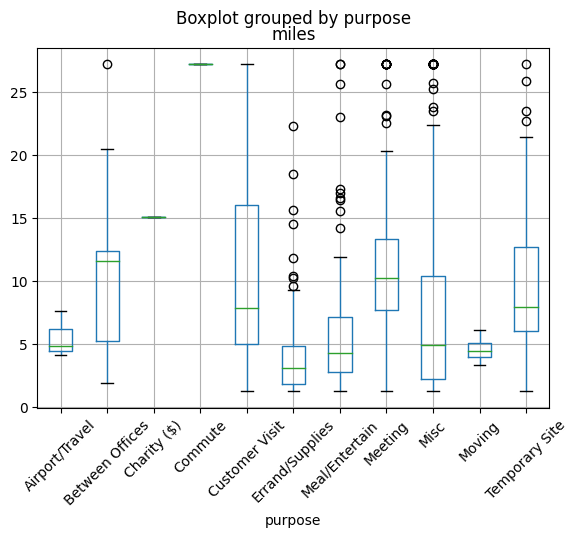

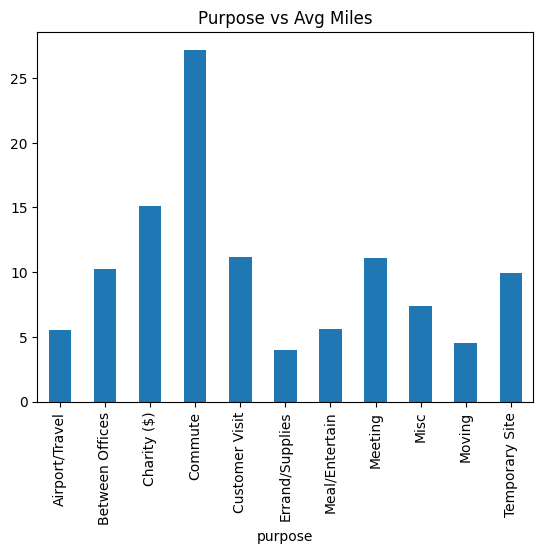

In [ ]:
# Stats by Purpose

# Boxplot
df.boxplot(column='miles', by='purpose')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

# Bar chart (average miles)
df.groupby('purpose')['miles'].mean().plot(kind='bar')
plt.title("Purpose vs Avg Miles")
plt.show()


### Use pivot tables to chart avg miles bya day and time


In [ ]:
# Couldnt pivot as there are duplicate entries
# The start and stop columns are not clean Unkown routes are high

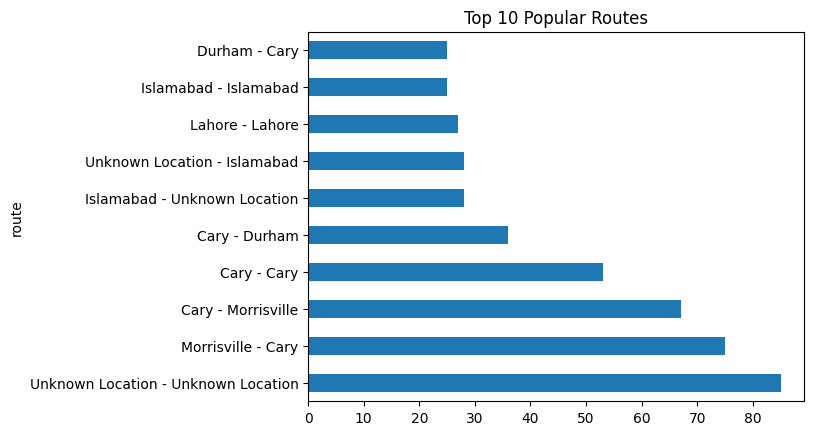

In [ ]:
# Top 10 routes
df['route'].value_counts().head(10).plot.barh()
plt.title('Top 10 Popular Routes')  # Title
plt.show()


## Stacked Chart
Plot top three routes by the month
Key Learning:  unstack()

<Figure size 1500x800 with 0 Axes>

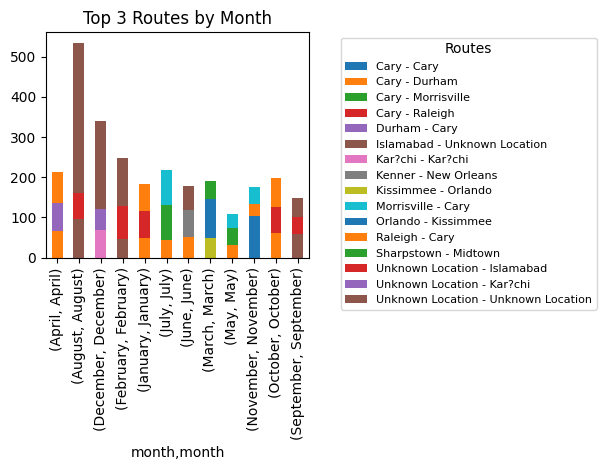

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_top_routes_by_month(df, n=3):
    return df.groupby(['month', 'route'])['miles'].sum().groupby(level=0).nlargest(n)

# ... (Assuming you have your 'df' DataFrame)

top_routes_by_month = get_top_routes_by_month(df.copy(), n=3)

# Increased figsize and adjustments for legend
plt.figure(figsize=(15, 8))
top_routes_by_month.unstack().plot(kind='bar', stacked=True)

# Legend placement and adjustments
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left', title='Routes', prop={'size': 8})
# Add a title
plt.title("Top 3 Routes by Month")  # Add your desired title here

plt.tight_layout()  # Improve overall spacing
plt.show()


## Addl Feature engg, Labeling andcorrelation


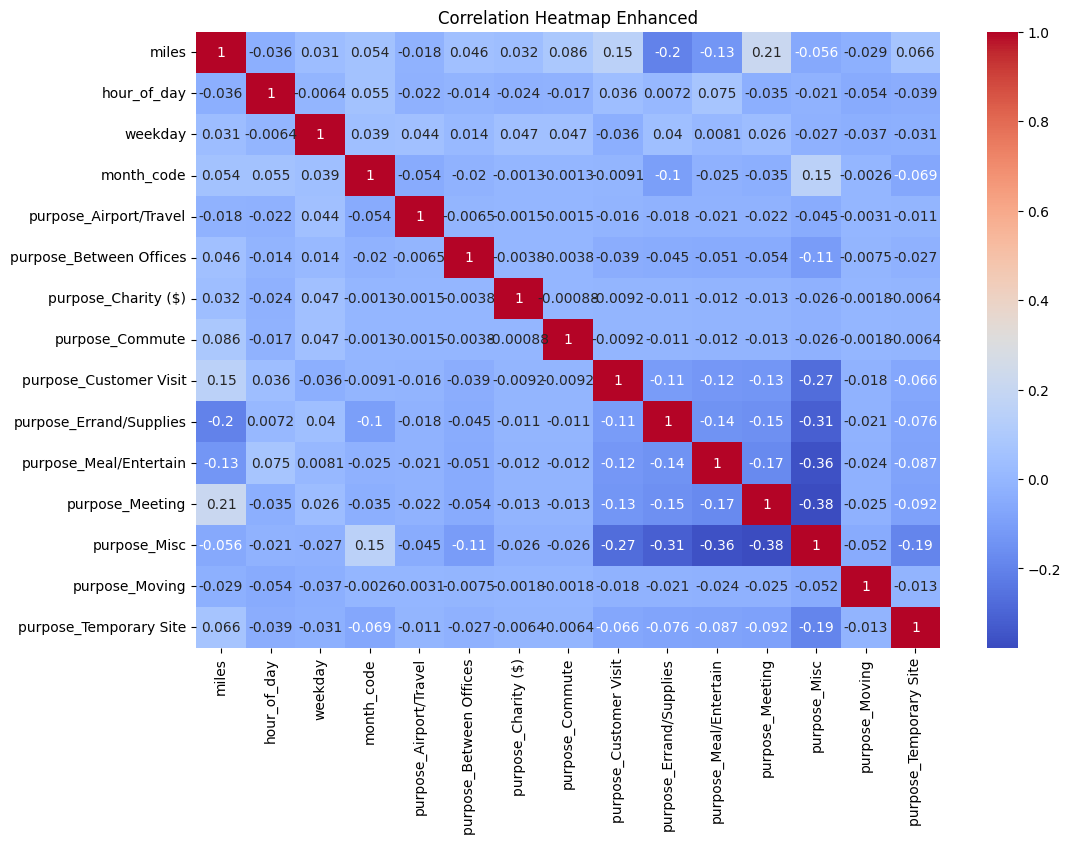

In [ ]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#  For correlation table only. The ML pipeline does this auto and you dont have to handle crazy number of fields

# Feature Engineering
df['hour_of_day'] = df['start_date'].dt.hour
df['weekday'] = df['start_date'].dt.dayofweek >= 5  # True for weekends

# Encoding
le = LabelEncoder()
df['month_code'] = le.fit_transform(df['month'])

ohe = OneHotEncoder(sparse=False)  # Sparse=False for a dense array
encoded_purpose = ohe.fit_transform(df[['purpose']])
new_purpose_cols = ohe.get_feature_names_out(['purpose'])  # Get new column names
df[new_purpose_cols] = encoded_purpose

# Select features for correlation
predictors = ['miles', 'hour_of_day', 'weekday', 'month_code'] + list(new_purpose_cols)

# Plot corr matrix use lib function. This also saves my corr matrix to my gdrive in excel
rak.plot_corr_matrix(df,predictors)



## Experiment with AI in python
My initial experiments of how to use Artificial Intelligence in data interpretation and decision making.

You can keep tweaking the predictor/featured col list in your corr matrix and get new results. Especially useful when corr matrix is huge.

This is standalone codeblock. Data set and fetured columns are selected without application of logic just for testing so interpretation is meaningless.

Work in progress

In [ ]:
import pandas as pd
from google.colab import drive
import google.generativeai as genai

# Step 1: Mount Google Drive - Not red if running notebook from start
drive.mount('/content/drive')

# Step 2: Function to read API key from Drive
def load_api_key():
  with open('/content/drive/My Drive/Dataset/api_key.txt', 'r') as f:  # File where I store my key
    api_key = f.read().strip()  # Remove any extra whitespace
    return api_key

# Step 3: Load the API key
api_key = load_api_key()
genai.configure(api_key=api_key)


# Step 3: Load the Gemini model
model = genai.GenerativeModel('gemini-pro')

# AI model is loaded and ready

# Balance code if for any interpretation. Made this standalone to just experiment

# Step 1: Load your df- not required if run in sequence in note book
csv_file_path = '/content/drive/My Drive/Dataset/videogames_3.csv'  # Load cleaned df

# Step 2: Read the CSV file into a DataFrame
df_AI = pd.read_csv(csv_file_path)
df_AI.columns
# Step 3: Calculate the correlation matrix
matrix = df_AI[['na_sales','year',
       'eu_sales', 'jp_sales', 'other_sales', 'global_sales'] ].corr()


# Step 4: Generate interpretation (Pass the matrix as plain text)
response = model.generate_content(f"Interpret the correlation matrix:\n{matrix.to_string()}")
print(response.text)
# You can engineer prompt to set significance levels and specific interpretation
# Eg relationship between features

**Interpretation:**

The correlation matrix shows the linear relationships between the different variables. The values range from -1 to 1, where:

* **-1:** Perfect negative correlation (as one variable increases, the other decreases in a linear fashion)
* **0:** No linear correlation (no relationship between the variables)
* **1:** Perfect positive correlation (as one variable increases, the other also increases in a linear fashion)

**Observations:**

* **na_sales** has a strong positive correlation with **eu_sales** (0.724) and **other_sales** (0.742), indicating that these variables tend to increase or decrease together.
* **year** has a very weak relationship with all other variables, with the strongest correlation being a negative 0.0476 with **na_sales**. This suggests that time alone has little impact on these variables.
* **global_sales** has a very strong positive correlation with all other variables, ranging from 0.83 to 0.9, indicating that increases in global sales are ass

## Rank by frequency/Dist
 Adds Columsn to the df rank by total dist and rank by total distance to every row based on the route

In [ ]:
# Adds columns with route ranks based on total distance and trip frequency.

def add_rank_columns(df):
  """
  Args:df

  Returns: modified df with two addl col rk by freq and rk by total mile

  """

  df['rank_by_total_distance'] = df.groupby('route')['miles'].transform('sum').rank(ascending=False)
  df['rank_by_frequency'] = df.groupby('route')['route'].transform('size')  # Equivalent to .count()

  return df
# call the function and feed to test col
df_test=pd.DataFrame()
df_test=add_rank_columns(df.copy())
display(df_test) ## Correctly captured
df=df_test  # After checking assign back to original df
# Data ready for ML

,start_date,end_date,category,start,stop,miles,purpose,duration,day,month,...,purpose_Commute,purpose_Customer Visit,purpose_Errand/Supplies,purpose_Meal/Entertain,purpose_Meeting,purpose_Misc,purpose_Moving,purpose_Temporary Site,rank_by_total_distance,rank_by_frequency
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,0 days 00:06:00,Friday,January,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,864.5,3
1,2016-02-01 01:25:00,2016-02-01 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,Misc,0 days 00:12:00,Monday,February,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,864.5,3
2,2016-02-01 20:25:00,2016-02-01 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,0 days 00:13:00,Monday,February,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,864.5,3
3,2016-06-01 14:42:00,2016-06-01 15:49:00,Business,Fort Pierce,West Palm Beach,27.2,Customer Visit,0 days 01:07:00,Wednesday,June,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,738.0,1
4,2016-06-01 17:15:00,2016-06-01 17:19:00,Business,West Palm Beach,West Palm Beach,4.3,Meal/Entertain,0 days 00:04:00,Wednesday,June,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1017.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,2016-12-31 01:07:00,2016-12-31 01:14:00,Business,Kar?chi,Kar?chi,1.2,Meeting,0 days 00:07:00,Saturday,December,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,586.5,20
1134,2016-12-31 13:24:00,2016-12-31 13:42:00,Business,Kar?chi,Unknown Location,3.9,Temporary Site,0 days 00:18:00,Saturday,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,632.0,7
1135,2016-12-31 15:03:00,2016-12-31 15:38:00,Business,Unknown Location,Unknown Location,16.2,Meeting,0 days 00:35:00,Saturday,December,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,43.0,85
1136,2016-12-31 21:32:00,2016-12-31 21:50:00,Business,Katunayake,Gampaha,6.4,Temporary Site,0 days 00:18:00,Saturday,December,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,957.0,1


## Machine Learning
Code is ready for ML
Note: run the total_distance through std scalar